## Reading the data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots
from statsmodels.tsa.arima_model import ARIMA
import datetime
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as pyplot
from pylab import rcParams
import statsmodels.api as sm
import itertools
import numpy as np

In [59]:
data = pd.read_csv('test_restaurant.csv')

In [60]:
data

,date,num_visitors
0,2000-01-01,49.128490
1,2000-01-02,50.288060
2,2000-01-03,53.549213
3,2000-01-04,45.453240
4,2000-01-05,49.469402
...,...,...
3646,2009-12-25,31.124632
3647,2009-12-26,27.293856
3648,2009-12-27,30.218498
3649,2009-12-28,24.751186


## Data Preprocessing

### Check for null values or empty strings

In [61]:
# NUll value check
data.isna().sum()

date            0
num_visitors    0
dtype: int64

In [62]:
# Empty string check
data['date'].eq('').sum()

0

### Check format of the date

In [63]:
# Convert to datetime to check if all the rows are in datetime format
check = pd.to_datetime(data['date'], errors='coerce').isna()

# Prints 0 if there are no errors
check.sum()


0

### Convert date to datetime format

In [64]:
data['date'] = pd.to_datetime(data['date'])

In [65]:
data = data.set_index('date')

In [66]:
data

,num_visitors
date,
2000-01-01,49.128490
2000-01-02,50.288060
2000-01-03,53.549213
2000-01-04,45.453240
2000-01-05,49.469402
...,...
2009-12-25,31.124632
2009-12-26,27.293856
2009-12-27,30.218498


## Data Exploration

### Draw time series

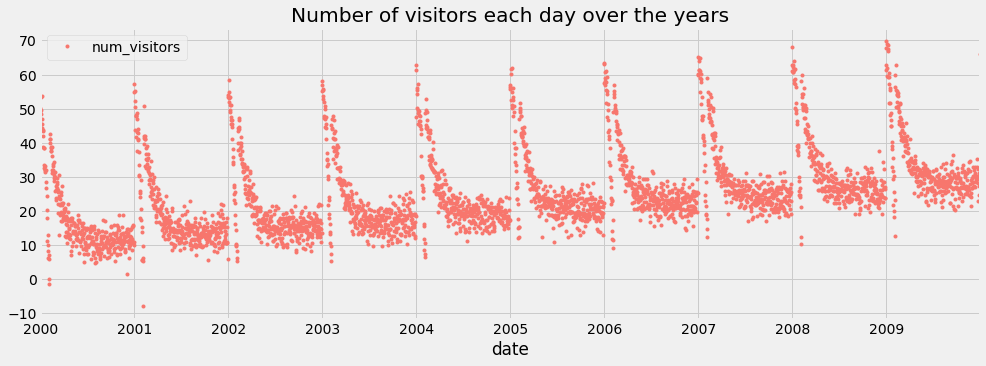

In [67]:
# Color pallete for plotting

data.plot(style='.', figsize=(15,5), color="#F8766D", title='Number of visitors each day over the years')
plt.show()

From the above graph, we can see that there is seasonality and upward trend involved which must be removed and analyzed.

### Checking the monthly, yearly and weekly trend

In [68]:
# Get the month, year, quarter and other paramters from date

def create_features(df,label):
    
    df['date']=df.index
    df['date'] = pd.to_datetime(df['date'])

    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear

    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    df = df[['dayofweek','quarter','month','year',
       'dayofyear','dayofmonth','weekofyear',label]]
    
    return df

In [13]:
data_features = create_features(data,'num_visitors')

In [14]:
data_features.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,num_visitors
date,,,,,,,,
2000-01-01,5,1,1,2000,1,1,52,49.128490
2000-01-02,6,1,1,2000,2,2,52,50.288060
2000-01-03,0,1,1,2000,3,3,1,53.549213
2000-01-04,1,1,1,2000,4,4,1,45.453240
2000-01-05,2,1,1,2000,5,5,1,49.469402


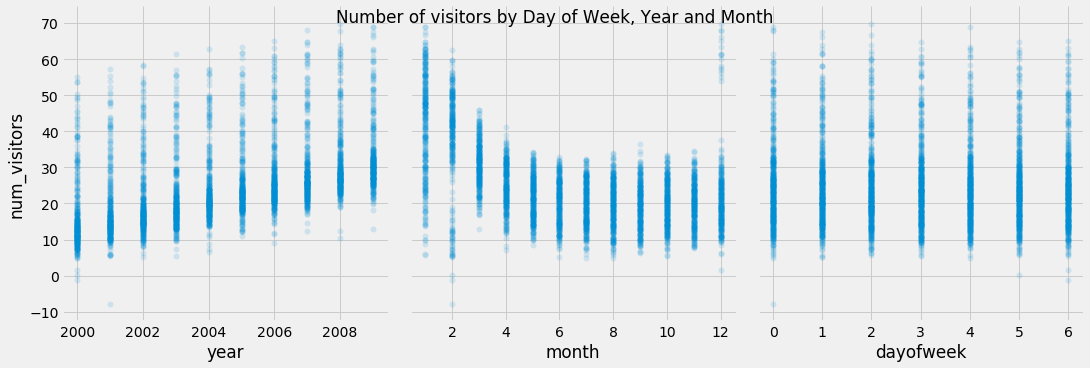

In [69]:
# Plot the trend for yearly, monthly and weekly trend

sns.pairplot(data_features,x_vars=['year','month','dayofweek'],y_vars='num_visitors',height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Number of visitors by Day of Week, Year and Month')
plt.show()

From the first graph, we can see that there is an overall upward trend in the number of visitors yearly. In the second graph, we can see the pattern which is followed every year over the months. January and February seems to have high number of visitors and decreases for the other months and again increases for december. In the 3rd graph, we can see that there is not much of difference in the number of visitors for different days of the week.

### Decomposition of the time series into its components

In [70]:
monthly_average = data['num_visitors'].resample('MS').mean()

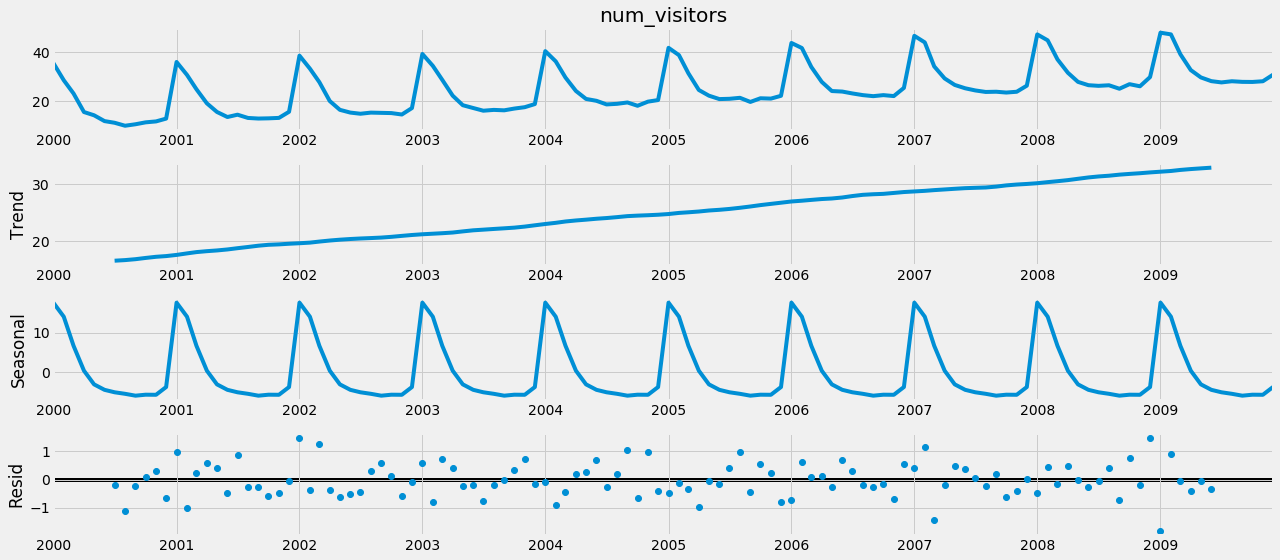

In [74]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(monthly_average, model='additive')
fig = decomposition.plot()
plt.show()

### Train and test split

In [18]:
split_date = '01-Jan-2008'
data_train = pd.DataFrame(data.loc[data.index <= split_date,'num_visitors'])
data_test = pd.DataFrame(data.loc[data.index > split_date,'num_visitors'])

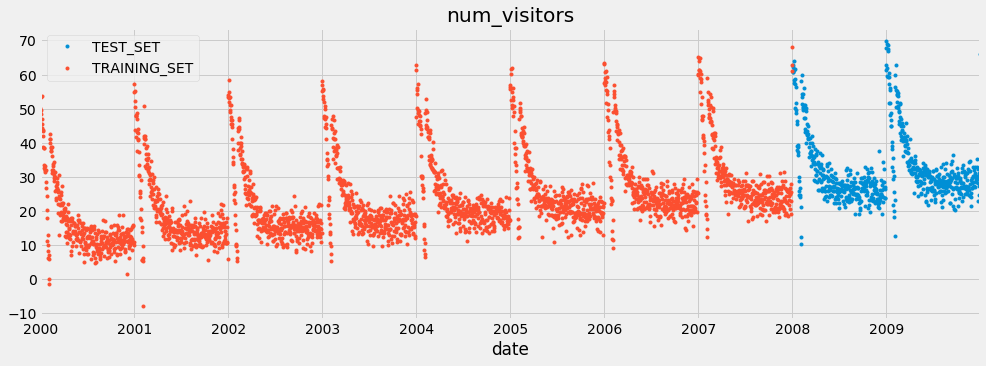

In [19]:
# Plot train and test so you can see where we have split
data_test.rename(columns={'num_visitors': 'TEST_SET'}).join(data_train.rename(columns={'num_visitors': 'TRAINING_SET'}),how='outer').plot(figsize=(15,5), title='num_visitors', style='.')
plt.show()

### ACF and PACF plots

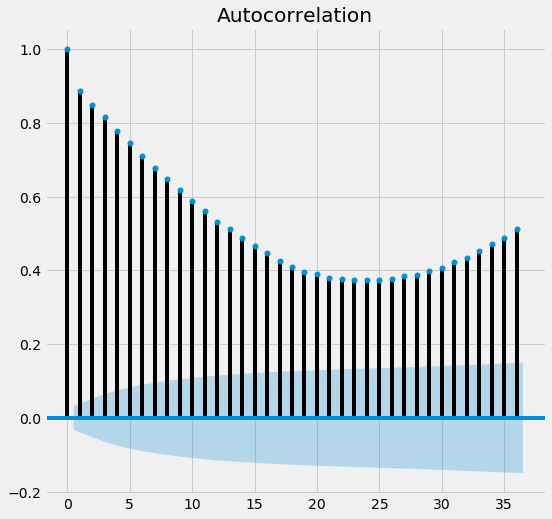

In [78]:
# Draw ACF and plot to check for seasonality and trend
rcParams['figure.figsize'] = 8, 8
plot_acf(data['num_visitors'])
pyplot.show()

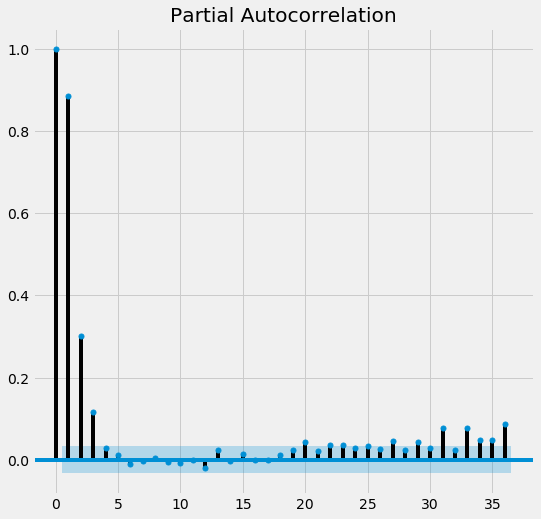

In [79]:
plot_pacf(data['num_visitors'])
pyplot.show()

The ACF is decreasing over time and then increasing. So there is a trend involved here.


### Differencing to remove trend

In [22]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

In [23]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

Since the data only has 10 years, differencing on 365 interval will not be effective. Hence, I have chosen 7 to difference to remove the trend.

In [24]:
interval = 7
differenced = difference(data['num_visitors'].values, interval)

### ACF and PACF after differencing

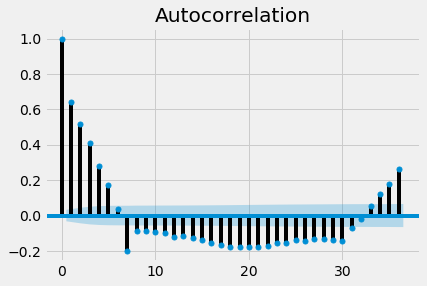

In [25]:
plot_acf(differenced)
pyplot.show()

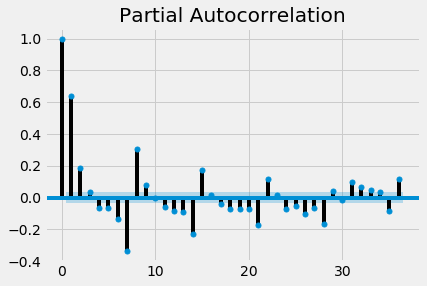

In [26]:
plot_pacf(differenced)
pyplot.show()

From the graphs we can see that the trend is now not as evident as before. From PACF, we can still find some seasonality though. 

We can first try and fit ARIMA. From the ACF and PACF, it looks like a suitable 'p' will most likely be in between 3 and 5. And I gave d=1 because of the differencing. So, I tried fitting ARIMA with (5,1,0)

### Fit the ARIMA model and forecasting

In [27]:
# fit model
model = ARIMA(differenced, order=(5,1,0))
model_fit = model.fit(disp=0)

In [28]:
forecast = model_fit.predict(start=len(data_train), end=len(data_train)+len(data_test)-1)

We have to take inverse difference of the forecast values to obtain the actual forecasted values

In [30]:
forecast2 = inverse_difference(data_test['num_visitors'].values, forecast, interval)

In [31]:
forecast2

array([31.43393007, 34.32240235, 31.201347  , 35.05985234, 30.2430198 ,
       30.7033897 , 35.52385664, 35.00440489, 28.94930308, 33.75916252,
       30.88812043, 35.29816783, 35.2190556 , 31.07240282, 30.68135031,
       34.15630216, 30.70240223, 30.67629119, 36.21145961, 29.72812335,
       30.33464597, 34.40868575, 32.61289087, 31.91741123, 31.08486635,
       29.67084805, 36.42232892, 33.7833457 , 13.43496621, 24.03443424,
       32.85630815, 32.14855873, 31.26310646, 27.51247335, 32.30293488,
       49.76999705, 40.17953469, 32.55939088, 29.95925417, 32.48726722,
       32.45747365, 30.93609846, 34.51497612, 31.47016762, 32.50153942,
       36.03190255, 28.58701458, 31.40693609, 35.67266505, 28.42180915,
       33.40617113, 31.44086134, 30.9112677 , 35.87504575, 32.42288254,
       27.95421456, 34.05344042, 31.76075083, 32.79503516, 34.38129064,
       31.39446562, 30.88865646, 34.26284283, 30.5734212 , 34.01439303,
       30.98526662, 29.87700644, 32.13034895, 34.65466773, 31.17

### Model evaluation using MAE

In [50]:
np.mean(abs(forecast2-data_test['num_visitors']))

7.13975568417555

There was some seasonality involved in the differenced data because of which the analysis may not be perfect. So, I am gonna try SARIMA where I can set my seasonality

### SARIMA

I have taken monthly average because SARIMA doesn't perform well on daily data and can be a little tricky

In [33]:
monthly_average = data2['num_visitors'].resample('MS').mean()

Create a grid search for finding optimum p,d,q and P,D,Q. I have taken S = 12, because of yearly seasonality

In [34]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


In [35]:
aic = 2000
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            print(param)
            print(param_seasonal)
            mod = sm.tsa.statespace.SARIMAX(monthly_average,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print(results)
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
            
            # Record the paramters which have least AIC
            if results.aic<aic:
                aic = results.aic
                param2 = param
                param_seasonal2 = param_seasonal
        except: 
            print('no')
            continue
            

(0, 0, 0)
(0, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1118.5790122313226
(0, 0, 0)
(0, 0, 1, 12)
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:904.7505501755546
(0, 0, 0)
(0, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:815.8467270123232
(0, 0, 0)
(0, 1, 0, 12)
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:455.33099767910653
(0, 0, 0)
(0, 1, 1, 12)
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:357.9525625112283
(0, 0, 0)
(0, 1, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:320.4023380751666
(0, 0, 0)
(0, 2, 0, 12)
ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:329.89436664574504
(0, 0, 0)
(0, 2, 1, 12)
ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:223.4897881411489
(0, 0, 0)
(0, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:2589.3667980052887
(0, 0, 0)
(1, 0, 0, 12)
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:331.0658693941677
(0, 0, 0)
(1, 0, 1, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:327.06712952999527
(0, 0, 0)
(1, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:281.8094749423431
(0, 0, 0)
(1, 1, 0, 12)
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:321.2335178990636
(0, 0, 0)
(1, 1, 1, 12)
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:263.85146558191224
(0, 0, 0)
(1, 1, 2, 12)
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:207.50445097454025
(0, 0, 0)
(1, 2, 0, 12)
ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:251.07128701299837
(0, 0, 0)
(1, 2, 1, 12)
ARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC:216.2489620743885
(0, 0, 0)
(1, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 2, 2, 12)12 - AIC:2777.781264692842
(0, 0, 0)
(2, 0, 0, 12)
ARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:280.27361279130537
(0, 0, 0)
(2, 0, 1, 12)
ARIMA(0, 0, 0)x(2, 0, 1, 12)12 - AIC:264.6013101204703
(0, 0, 0)
(2, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(2, 0, 2, 12)12 - AIC:248.62309417038423
(0, 0, 0)
(2, 1, 0, 12)
ARIMA(0, 0, 0)x(2, 1, 0, 12)12 - AIC:249.45882845104273
(0, 0, 0)
(2, 1, 1, 12)
ARIMA(0, 0, 0)x(2, 1, 1, 12)12 - AIC:220.74755130113658
(0, 0, 0)
(2, 1, 2, 12)
ARIMA(0, 0, 0)x(2, 1, 2, 12)12 - AIC:219.41471379261992
(0, 0, 0)
(2, 2, 0, 12)
ARIMA(0, 0, 0)x(2, 2, 0, 12)12 - AIC:197.45357809323755
(0, 0, 0)
(2, 2, 1, 12)
ARIMA(0, 0, 0)x(2, 2, 1, 12)12 - AIC:182.22330017968247
(0, 0, 0)
(2, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(2, 2, 2, 12)12 - AIC:2905.14398048643
(0, 0, 1)
(0, 0, 0, 12)
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:987.0368108887552
(0, 0, 1)
(0, 0, 1, 12)
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:785.2636838195907
(0, 0, 1)
(0, 0, 2, 12)
ARIMA(0, 0, 1)x(0, 0, 2, 12)12 - AIC:632.1632833396375
(0, 0, 1)
(0, 1, 0, 12)
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:391.8530188720577
(0, 0, 1)
(0, 1, 1, 12)
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:331.43257861422614
(0, 0, 1)
(0, 1, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(0, 1, 2, 12)12 - AIC:297.02633412231074
(0, 0, 1)
(0, 2, 0, 12)
ARIMA(0, 0, 1)x(0, 2, 0, 12)12 - AIC:328.55786168110023
(0, 0, 1)
(0, 2, 1, 12)
ARIMA(0, 0, 1)x(0, 2, 1, 12)12 - AIC:221.8281703054756
(0, 0, 1)
(0, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(0, 2, 2, 12)12 - AIC:2922.1555100977503
(0, 0, 1)
(1, 0, 0, 12)
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:324.63401890914884
(0, 0, 1)
(1, 0, 1, 12)
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:319.0685217749105
(0, 0, 1)
(1, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 2, 12)12 - AIC:277.40636336691364
(0, 0, 1)
(1, 1, 0, 12)
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.668158464287
(0, 0, 1)
(1, 1, 1, 12)
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:262.773591091238
(0, 0, 1)
(1, 1, 2, 12)
ARIMA(0, 0, 1)x(1, 1, 2, 12)12 - AIC:207.1074180664619
(0, 0, 1)
(1, 2, 0, 12)
ARIMA(0, 0, 1)x(1, 2, 0, 12)12 - AIC:252.35845595190065
(0, 0, 1)
(1, 2, 1, 12)
ARIMA(0, 0, 1)x(1, 2, 1, 12)12 - AIC:214.32714996323432
(0, 0, 1)
(1, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 2, 2, 12)12 - AIC:2817.193417338046
(0, 0, 1)
(2, 0, 0, 12)
ARIMA(0, 0, 1)x(2, 0, 0, 12)12 - AIC:278.86177081643825
(0, 0, 1)
(2, 0, 1, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(2, 0, 1, 12)12 - AIC:268.37031251287954
(0, 0, 1)
(2, 0, 2, 12)
ARIMA(0, 0, 1)x(2, 0, 2, 12)12 - AIC:260.57851790970454
(0, 0, 1)
(2, 1, 0, 12)
ARIMA(0, 0, 1)x(2, 1, 0, 12)12 - AIC:250.28644309225993
(0, 0, 1)
(2, 1, 1, 12)
ARIMA(0, 0, 1)x(2, 1, 1, 12)12 - AIC:221.86846127744516
(0, 0, 1)
(2, 1, 2, 12)
ARIMA(0, 0, 1)x(2, 1, 2, 12)12 - AIC:217.44727780950444
(0, 0, 1)
(2, 2, 0, 12)
ARIMA(0, 0, 1)x(2, 2, 0, 12)12 - AIC:198.7378148865658
(0, 0, 1)
(2, 2, 1, 12)
ARIMA(0, 0, 1)x(2, 2, 1, 12)12 - AIC:183.79442860418595
(0, 0, 1)
(2, 2, 2, 12)
ARIMA(0, 0, 1)x(2, 2, 2, 12)12 - AIC:2868.030883568974
(0, 0, 2)
(0, 0, 0, 12)
ARIMA(0, 0, 2)x(0, 0, 0, 12)12 - AIC:883.166748037425
(0, 0, 2)
(0, 0, 1, 12)
ARIMA(0, 0, 2)x(0, 0, 1, 12)12 - AIC:709.0191930021381
(0, 0, 2)
(0, 0, 2, 12)
ARIMA(0, 0, 2)x(0, 0, 2, 12)12 - AIC:593.0792724923912
(0, 0, 2)
(0, 1, 0, 12)
ARIMA(0, 0, 2)x(0, 1, 0, 12)12 - AIC:358.83806808368803
(0, 0, 2)
(0, 1, 1, 12)
ARIMA(0, 0, 2)x(0, 1, 1, 12)12 - AIC:312.32199

C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 2)x(0, 1, 2, 12)12 - AIC:279.34475283106667
(0, 0, 2)
(0, 2, 0, 12)
ARIMA(0, 0, 2)x(0, 2, 0, 12)12 - AIC:326.4617836935759
(0, 0, 2)
(0, 2, 1, 12)
ARIMA(0, 0, 2)x(0, 2, 1, 12)12 - AIC:220.15383681766767
(0, 0, 2)
(0, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 2)x(0, 2, 2, 12)12 - AIC:3248.0564878425444
(0, 0, 2)
(1, 0, 0, 12)
ARIMA(0, 0, 2)x(1, 0, 0, 12)12 - AIC:320.99334302513523
(0, 0, 2)
(1, 0, 1, 12)
ARIMA(0, 0, 2)x(1, 0, 1, 12)12 - AIC:314.5511682940885
(0, 0, 2)
(1, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 2)x(1, 0, 2, 12)12 - AIC:271.0494051641635
(0, 0, 2)
(1, 1, 0, 12)
ARIMA(0, 0, 2)x(1, 1, 0, 12)12 - AIC:315.6149373943489
(0, 0, 2)
(1, 1, 1, 12)
ARIMA(0, 0, 2)x(1, 1, 1, 12)12 - AIC:261.43052739913685
(0, 0, 2)
(1, 1, 2, 12)
ARIMA(0, 0, 2)x(1, 1, 2, 12)12 - AIC:206.76703746568245
(0, 0, 2)
(1, 2, 0, 12)
ARIMA(0, 0, 2)x(1, 2, 0, 12)12 - AIC:254.2074423405378
(0, 0, 2)
(1, 2, 1, 12)
ARIMA(0, 0, 2)x(1, 2, 1, 12)12 - AIC:212.64949976758007
(0, 0, 2)
(1, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 2)x(1, 2, 2, 12)12 - AIC:3144.6240648588
(0, 0, 2)
(2, 0, 0, 12)
ARIMA(0, 0, 2)x(2, 0, 0, 12)12 - AIC:277.91728512059706
(0, 0, 2)
(2, 0, 1, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 2)x(2, 0, 1, 12)12 - AIC:268.11253654197685
(0, 0, 2)
(2, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 2)x(2, 0, 2, 12)12 - AIC:254.15852723720153
(0, 0, 2)
(2, 1, 0, 12)
ARIMA(0, 0, 2)x(2, 1, 0, 12)12 - AIC:251.68697847282309
(0, 0, 2)
(2, 1, 1, 12)
ARIMA(0, 0, 2)x(2, 1, 1, 12)12 - AIC:223.86757698271686
(0, 0, 2)
(2, 1, 2, 12)
ARIMA(0, 0, 2)x(2, 1, 2, 12)12 - AIC:215.63599879576878
(0, 0, 2)
(2, 2, 0, 12)
ARIMA(0, 0, 2)x(2, 2, 0, 12)12 - AIC:200.62680046202226
(0, 0, 2)
(2, 2, 1, 12)
ARIMA(0, 0, 2)x(2, 2, 1, 12)12 - AIC:185.786306152506
(0, 0, 2)
(2, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 2)x(2, 2, 2, 12)12 - AIC:3194.7638665893983
(0, 1, 0)
(0, 0, 0, 12)
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:786.8699052420452
(0, 1, 0)
(0, 0, 1, 12)
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:602.1004104925069
(0, 1, 0)
(0, 0, 2, 12)
ARIMA(0, 1, 0)x(0, 0, 2, 12)12 - AIC:481.8263358091692
(0, 1, 0)
(0, 1, 0, 12)
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:322.31932651233177
(0, 1, 0)
(0, 1, 1, 12)
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:270.0926478756694
(0, 1, 0)
(0, 1, 2, 12)
ARIMA(0, 1, 0)x(0, 1, 2, 12)12 - AIC:239.2423026350553
(0, 1, 0)
(0, 2, 0, 12)
ARIMA(0, 1, 0)x(0, 2, 0, 12)12 - AIC:380.73739419566
(0, 1, 0)
(0, 2, 1, 12)
ARIMA(0, 1, 0)x(0, 2, 1, 12)12 - AIC:271.52049565454564
(0, 1, 0)
(0, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 2, 2, 12)12 - AIC:nan
(0, 1, 0)
(1, 0, 0, 12)
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:323.5007311336255
(0, 1, 0)
(1, 0, 1, 12)
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:301.8011898441694
(0, 1, 0)
(1, 0, 2, 12)
ARIMA(0, 1, 0)x(1, 0, 2, 12)12 - AIC:269.55215487206044
(0, 1, 0)
(1, 1, 0, 12)
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:274.15488365147985
(0, 1, 0)
(1, 1, 1, 12)
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:271.6731317812555
(0, 1, 0)
(1, 1, 2, 12)
ARIMA(0, 1, 0)x(1, 1, 2, 12)12 - AIC:241.24218681311086
(0, 1, 0)
(1, 2, 0, 12)
ARIMA(0, 1, 0)x(1, 2, 0, 12)12 - AIC:297.83737939869366
(0, 1, 0)
(1, 2, 1, 12)
ARIMA(0, 1, 0)x(1, 2, 1, 12)12 - AIC:263.40817938828246
(0, 1, 0)
(1, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 2, 2, 12)12 - AIC:2584.7286132154572
(0, 1, 0)
(2, 0, 0, 12)
ARIMA(0, 1, 0)x(2, 0, 0, 12)12 - AIC:270.6785004375387
(0, 1, 0)
(2, 0, 1, 12)
ARIMA(0, 1, 0)x(2, 0, 1, 12)12 - AIC:269.83200891414185
(0, 1, 0)
(2, 0, 2, 12)
ARIMA(0, 1, 0)x(2, 0, 2, 12)12 - AIC:269.8151326611698
(0, 1, 0)
(2, 1, 0, 12)
ARIMA(0, 1, 0)x(2, 1, 0, 12)12 - AIC:240.15547333759983
(0, 1, 0)
(2, 1, 1, 12)
ARIMA(0, 1, 0)x(2, 1, 1, 12)12 - AIC:242.12478896019806
(0, 1, 0)
(2, 1, 2, 12)
ARIMA(0, 1, 0)x(2, 1, 2, 12)12 - AIC:241.2290287757537
(0, 1, 0)
(2, 2, 0, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(2, 2, 0, 12)12 - AIC:236.33194283981464
(0, 1, 0)
(2, 2, 1, 12)
ARIMA(0, 1, 0)x(2, 2, 1, 12)12 - AIC:223.9326200574512
(0, 1, 0)
(2, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(2, 2, 2, 12)12 - AIC:3115.1519394362454
(0, 1, 1)
(0, 0, 0, 12)
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:780.5981304018499
(0, 1, 1)
(0, 0, 1, 12)
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:597.3938523468786
(0, 1, 1)
(0, 0, 2, 12)
ARIMA(0, 1, 1)x(0, 0, 2, 12)12 - AIC:479.438667233285
(0, 1, 1)
(0, 1, 0, 12)
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:262.26540704397644
(0, 1, 1)
(0, 1, 1, 12)
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:209.65479095627248
(0, 1, 1)
(0, 1, 2, 12)
ARIMA(0, 1, 1)x(0, 1, 2, 12)12 - AIC:184.1516269513649
(0, 1, 1)
(0, 2, 0, 12)
ARIMA(0, 1, 1)x(0, 2, 0, 12)12 - AIC:331.87308072956677
(0, 1, 1)
(0, 2, 1, 12)
ARIMA(0, 1, 1)x(0, 2, 1, 12)12 - AIC:226.35434471572194
(0, 1, 1)
(0, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 2, 2, 12)12 - AIC:nan
(0, 1, 1)
(1, 0, 0, 12)
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:268.20436373657867
(0, 1, 1)
(1, 0, 1, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:264.91651729115364
(0, 1, 1)
(1, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 0, 2, 12)12 - AIC:215.1552273351087
(0, 1, 1)
(1, 1, 0, 12)
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:218.75707888228362
(0, 1, 1)
(1, 1, 1, 12)
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:211.70102114276423
(0, 1, 1)
(1, 1, 2, 12)
ARIMA(0, 1, 1)x(1, 1, 2, 12)12 - AIC:184.58955715286817
(0, 1, 1)
(1, 2, 0, 12)
ARIMA(0, 1, 1)x(1, 2, 0, 12)12 - AIC:255.4624080658243
(0, 1, 1)
(1, 2, 1, 12)
ARIMA(0, 1, 1)x(1, 2, 1, 12)12 - AIC:220.82321242337323
(0, 1, 1)
(1, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 2, 2, 12)12 - AIC:2734.7093589970455
(0, 1, 1)
(2, 0, 0, 12)
ARIMA(0, 1, 1)x(2, 0, 0, 12)12 - AIC:219.88018293502063
(0, 1, 1)
(2, 0, 1, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(2, 0, 1, 12)12 - AIC:222.92420503879126
(0, 1, 1)
(2, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(2, 0, 2, 12)12 - AIC:223.97166867675338
(0, 1, 1)
(2, 1, 0, 12)
ARIMA(0, 1, 1)x(2, 1, 0, 12)12 - AIC:187.95384024574741
(0, 1, 1)
(2, 1, 1, 12)
ARIMA(0, 1, 1)x(2, 1, 1, 12)12 - AIC:189.94616575506987
(0, 1, 1)
(2, 1, 2, 12)
ARIMA(0, 1, 1)x(2, 1, 2, 12)12 - AIC:187.49507103177413
(0, 1, 1)
(2, 2, 0, 12)
ARIMA(0, 1, 1)x(2, 2, 0, 12)12 - AIC:202.0639706439297
(0, 1, 1)
(2, 2, 1, 12)
ARIMA(0, 1, 1)x(2, 2, 1, 12)12 - AIC:188.52788328255303
(0, 1, 1)
(2, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(2, 2, 2, 12)12 - AIC:2667.137702184597
(0, 1, 2)
(0, 0, 0, 12)
ARIMA(0, 1, 2)x(0, 0, 0, 12)12 - AIC:765.037879757302
(0, 1, 2)
(0, 0, 1, 12)
ARIMA(0, 1, 2)x(0, 0, 1, 12)12 - AIC:582.8300862903968
(0, 1, 2)
(0, 0, 2, 12)
ARIMA(0, 1, 2)x(0, 0, 2, 12)12 - AIC:463.25061075623023
(0, 1, 2)
(0, 1, 0, 12)
ARIMA(0, 1, 2)x(0, 1, 0, 12)12 - AIC:256.8855202600444
(0, 1, 2)
(0, 1, 1, 12)
ARIMA(0, 1, 2)x(0, 1, 1, 12)12 - AIC:208.2640448281004
(0, 1, 2)
(0, 1, 2, 12)
ARIMA(0, 1, 2)x(0, 1, 2, 12)12 - AIC:184.76805510142844
(0, 1, 2)
(0, 2, 0, 12)
ARIMA(0, 1, 2)x(0, 2, 0, 12)12 - AIC:324.029464877853
(0, 1, 2)
(0, 2, 1, 12)
ARIMA(0, 1, 2)x(0, 2, 1, 12)12 - AIC:225.18442543252513
(0, 1, 2)
(0, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(0, 2, 2, 12)12 - AIC:nan
(0, 1, 2)
(1, 0, 0, 12)
ARIMA(0, 1, 2)x(1, 0, 0, 12)12 - AIC:269.5067133526378
(0, 1, 2)
(1, 0, 1, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(1, 0, 1, 12)12 - AIC:263.8573000648723
(0, 1, 2)
(1, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(1, 0, 2, 12)12 - AIC:210.9339561128211
(0, 1, 2)
(1, 1, 0, 12)
ARIMA(0, 1, 2)x(1, 1, 0, 12)12 - AIC:220.53594636671306
(0, 1, 2)
(1, 1, 1, 12)
ARIMA(0, 1, 2)x(1, 1, 1, 12)12 - AIC:209.3508634122797
(0, 1, 2)
(1, 1, 2, 12)
ARIMA(0, 1, 2)x(1, 1, 2, 12)12 - AIC:184.9706941254908
(0, 1, 2)
(1, 2, 0, 12)
ARIMA(0, 1, 2)x(1, 2, 0, 12)12 - AIC:256.58878543831526
(0, 1, 2)
(1, 2, 1, 12)
ARIMA(0, 1, 2)x(1, 2, 1, 12)12 - AIC:218.53229525624653
(0, 1, 2)
(1, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(1, 2, 2, 12)12 - AIC:2980.089237214716
(0, 1, 2)
(2, 0, 0, 12)
ARIMA(0, 1, 2)x(2, 0, 0, 12)12 - AIC:221.51820248842392
(0, 1, 2)
(2, 0, 1, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(2, 0, 1, 12)12 - AIC:224.77334699380643
(0, 1, 2)
(2, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(2, 0, 2, 12)12 - AIC:225.93838937851265
(0, 1, 2)
(2, 1, 0, 12)
ARIMA(0, 1, 2)x(2, 1, 0, 12)12 - AIC:189.917392339785
(0, 1, 2)
(2, 1, 1, 12)
ARIMA(0, 1, 2)x(2, 1, 1, 12)12 - AIC:191.90429274824524
(0, 1, 2)
(2, 1, 2, 12)
ARIMA(0, 1, 2)x(2, 1, 2, 12)12 - AIC:186.19189031166354
(0, 1, 2)
(2, 2, 0, 12)
ARIMA(0, 1, 2)x(2, 2, 0, 12)12 - AIC:203.1437382259255
(0, 1, 2)
(2, 2, 1, 12)
ARIMA(0, 1, 2)x(2, 2, 1, 12)12 - AIC:190.16214178174178
(0, 1, 2)
(2, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(2, 2, 2, 12)12 - AIC:3142.091825299256
(0, 2, 0)
(0, 0, 0, 12)
ARIMA(0, 2, 0)x(0, 0, 0, 12)12 - AIC:848.3906427020725
(0, 2, 0)
(0, 0, 1, 12)
ARIMA(0, 2, 0)x(0, 0, 1, 12)12 - AIC:650.0669382870627
(0, 2, 0)
(0, 0, 2, 12)
ARIMA(0, 2, 0)x(0, 0, 2, 12)12 - AIC:528.7808614416896
(0, 2, 0)
(0, 1, 0, 12)
ARIMA(0, 2, 0)x(0, 1, 0, 12)12 - AIC:434.7412011553178
(0, 2, 0)
(0, 1, 1, 12)
ARIMA(0, 2, 0)x(0, 1, 1, 12)12 - AIC:372.06732988846403
(0, 2, 0)
(0, 1, 2, 12)
ARIMA(0, 2, 0)x(0, 1, 2, 12)12 - AIC:326.63405786652925
(0, 2, 0)
(0, 2, 0, 12)
ARIMA(0, 2, 0)x(0, 2, 0, 12)12 - AIC:478.7860746071892
(0, 2, 0)
(0, 2, 1, 12)
ARIMA(0, 2, 0)x(0, 2, 1, 12)12 - AIC:356.9608024161613
(0, 2, 0)
(0, 2, 2, 12)
ARIMA(0, 2, 0)x(0, 2, 2, 12)12 - AIC:2908.8817441057245
(0, 2, 0)
(1, 0, 0, 12)
ARIMA(0, 2, 0)x(1, 0, 0, 12)12 - AIC:431.6533453224629
(0, 2, 0)
(1, 0, 1, 12)
ARIMA(0, 2, 0)x(1, 0, 1, 12)12 - AIC:408.53351814384143
(0, 2, 0)
(1, 0, 2, 12)
ARIMA(0, 2, 0)x(1, 0, 2, 12)12 - AIC:364.5430926

C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 2, 1)x(0, 2, 2, 12)12 - AIC:nan
(0, 2, 1)
(1, 0, 0, 12)
ARIMA(0, 2, 1)x(1, 0, 0, 12)12 - AIC:328.182067825769
(0, 2, 1)
(1, 0, 1, 12)
ARIMA(0, 2, 1)x(1, 0, 1, 12)12 - AIC:304.1150236989234
(0, 2, 1)
(1, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 2, 1)x(1, 0, 2, 12)12 - AIC:270.4667197663007
(0, 2, 1)
(1, 1, 0, 12)
ARIMA(0, 2, 1)x(1, 1, 0, 12)12 - AIC:278.85794210887565
(0, 2, 1)
(1, 1, 1, 12)
ARIMA(0, 2, 1)x(1, 1, 1, 12)12 - AIC:271.90517730134997
(0, 2, 1)
(1, 1, 2, 12)
ARIMA(0, 2, 1)x(1, 1, 2, 12)12 - AIC:241.9244632916201
(0, 2, 1)
(1, 2, 0, 12)
ARIMA(0, 2, 1)x(1, 2, 0, 12)12 - AIC:301.7090742717187
(0, 2, 1)
(1, 2, 1, 12)
ARIMA(0, 2, 1)x(1, 2, 1, 12)12 - AIC:265.17951079073214
(0, 2, 1)
(1, 2, 2, 12)
ARIMA(0, 2, 1)x(1, 2, 2, 12)12 - AIC:4880.8881162591515
(0, 2, 1)
(2, 0, 0, 12)
ARIMA(0, 2, 1)x(2, 0, 0, 12)12 - AIC:275.43699296660986
(0, 2, 1)
(2, 0, 1, 12)
ARIMA(0, 2, 1)x(2, 0, 1, 12)12 - AIC:275.1732918327043
(0, 2, 1)
(2, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 2, 1)x(2, 0, 2, 12)12 - AIC:270.2888258787941
(0, 2, 1)
(2, 1, 0, 12)
ARIMA(0, 2, 1)x(2, 1, 0, 12)12 - AIC:244.7379779434529
(0, 2, 1)
(2, 1, 1, 12)
ARIMA(0, 2, 1)x(2, 1, 1, 12)12 - AIC:246.73720707910394
(0, 2, 1)
(2, 1, 2, 12)
ARIMA(0, 2, 1)x(2, 1, 2, 12)12 - AIC:242.86535212173987
(0, 2, 1)
(2, 2, 0, 12)
ARIMA(0, 2, 1)x(2, 2, 0, 12)12 - AIC:240.33116507752584
(0, 2, 1)
(2, 2, 1, 12)
ARIMA(0, 2, 1)x(2, 2, 1, 12)12 - AIC:229.96186521150358
(0, 2, 1)
(2, 2, 2, 12)
ARIMA(0, 2, 1)x(2, 2, 2, 12)12 - AIC:4475.877594688365
(0, 2, 2)
(0, 0, 0, 12)
ARIMA(0, 2, 2)x(0, 0, 0, 12)12 - AIC:775.0285564842296
(0, 2, 2)
(0, 0, 1, 12)
ARIMA(0, 2, 2)x(0, 0, 1, 12)12 - AIC:593.2703678051412
(0, 2, 2)
(0, 0, 2, 12)
ARIMA(0, 2, 2)x(0, 0, 2, 12)12 - AIC:474.7547610450546
(0, 2, 2)
(0, 1, 0, 12)
ARIMA(0, 2, 2)x(0, 1, 0, 12)12 - AIC:265.97232246644313
(0, 2, 2)
(0, 1, 1, 12)
ARIMA(0, 2, 2)x(0, 1, 1, 12)12 - AIC:210.05553552151179
(0, 2, 2)
(0, 1, 2, 12)
ARIMA(0, 2, 2)x(0, 1, 2, 12)12 - AIC:190.00794

C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 2, 2)x(1, 0, 1, 12)12 - AIC:270.83100648468917
(0, 2, 2)
(1, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 2, 2)x(1, 0, 2, 12)12 - AIC:221.47347178326027
(0, 2, 2)
(1, 1, 0, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 2, 2)x(1, 1, 0, 12)12 - AIC:230.7242176669144
(0, 2, 2)
(1, 1, 1, 12)
ARIMA(0, 2, 2)x(1, 1, 1, 12)12 - AIC:217.8338467225586
(0, 2, 2)
(1, 1, 2, 12)
ARIMA(0, 2, 2)x(1, 1, 2, 12)12 - AIC:190.82009755255677
(0, 2, 2)
(1, 2, 0, 12)
ARIMA(0, 2, 2)x(1, 2, 0, 12)12 - AIC:265.6868909695995
(0, 2, 2)
(1, 2, 1, 12)
ARIMA(0, 2, 2)x(1, 2, 1, 12)12 - AIC:226.63438967320224
(0, 2, 2)
(1, 2, 2, 12)
ARIMA(0, 2, 2)x(1, 2, 2, 12)12 - AIC:2781.6639487687203
(0, 2, 2)
(2, 0, 0, 12)
ARIMA(0, 2, 2)x(2, 0, 0, 12)12 - AIC:231.5291479803695
(0, 2, 2)
(2, 0, 1, 12)
ARIMA(0, 2, 2)x(2, 0, 1, 12)12 - AIC:228.37355089599936
(0, 2, 2)
(2, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 2, 2)x(2, 0, 2, 12)12 - AIC:221.51964830961285
(0, 2, 2)
(2, 1, 0, 12)
ARIMA(0, 2, 2)x(2, 1, 0, 12)12 - AIC:198.98625189678683
(0, 2, 2)
(2, 1, 1, 12)
ARIMA(0, 2, 2)x(2, 1, 1, 12)12 - AIC:200.98584918857637
(0, 2, 2)
(2, 1, 2, 12)
ARIMA(0, 2, 2)x(2, 1, 2, 12)12 - AIC:193.4920928931034
(0, 2, 2)
(2, 2, 0, 12)
ARIMA(0, 2, 2)x(2, 2, 0, 12)12 - AIC:211.99606818322377
(0, 2, 2)
(2, 2, 1, 12)
ARIMA(0, 2, 2)x(2, 2, 1, 12)12 - AIC:198.25225736888524
(0, 2, 2)
(2, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 2, 2)x(2, 2, 2, 12)12 - AIC:2955.078384176319
(1, 0, 0)
(0, 0, 0, 12)
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:793.4195139269734
(1, 0, 0)
(0, 0, 1, 12)
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:608.2448802438387
(1, 0, 0)
(0, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 0, 2, 12)12 - AIC:544.2194174044232
(1, 0, 0)
(0, 1, 0, 12)
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:320.57376208890236
(1, 0, 0)
(0, 1, 1, 12)
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:271.7280992728931
(1, 0, 0)
(0, 1, 2, 12)
ARIMA(1, 0, 0)x(0, 1, 2, 12)12 - AIC:241.47534265371095
(1, 0, 0)
(0, 2, 0, 12)
ARIMA(1, 0, 0)x(0, 2, 0, 12)12 - AIC:330.84085404144463
(1, 0, 0)
(0, 2, 1, 12)
ARIMA(1, 0, 0)x(0, 2, 1, 12)12 - AIC:224.96871180231835
(1, 0, 0)
(0, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 2, 2, 12)12 - AIC:2694.6942185354665
(1, 0, 0)
(1, 0, 0, 12)
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:321.2658284916068
(1, 0, 0)
(1, 0, 1, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:318.36693841710843
(1, 0, 0)
(1, 0, 2, 12)
ARIMA(1, 0, 0)x(1, 0, 2, 12)12 - AIC:273.33163146828355
(1, 0, 0)
(1, 1, 0, 12)
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:272.4394336731894
(1, 0, 0)
(1, 1, 1, 12)
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:264.85715257659444
(1, 0, 0)
(1, 1, 2, 12)
ARIMA(1, 0, 0)x(1, 1, 2, 12)12 - AIC:208.94780449661724
(1, 0, 0)
(1, 2, 0, 12)
ARIMA(1, 0, 0)x(1, 2, 0, 12)12 - AIC:250.11910833364738
(1, 0, 0)
(1, 2, 1, 12)
ARIMA(1, 0, 0)x(1, 2, 1, 12)12 - AIC:217.4823382847858
(1, 0, 0)
(1, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 2, 2, 12)12 - AIC:2588.3377641878574
(1, 0, 0)
(2, 0, 0, 12)
ARIMA(1, 0, 0)x(2, 0, 0, 12)12 - AIC:275.56319230192616
(1, 0, 0)
(2, 0, 1, 12)
ARIMA(1, 0, 0)x(2, 0, 1, 12)12 - AIC:264.0049532233686
(1, 0, 0)
(2, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(2, 0, 2, 12)12 - AIC:254.81073872999482
(1, 0, 0)
(2, 1, 0, 12)
ARIMA(1, 0, 0)x(2, 1, 0, 12)12 - AIC:248.10109300842004
(1, 0, 0)
(2, 1, 1, 12)
ARIMA(1, 0, 0)x(2, 1, 1, 12)12 - AIC:219.20508050912966
(1, 0, 0)
(2, 1, 2, 12)
ARIMA(1, 0, 0)x(2, 1, 2, 12)12 - AIC:220.5889536220154
(1, 0, 0)
(2, 2, 0, 12)
ARIMA(1, 0, 0)x(2, 2, 0, 12)12 - AIC:197.06089055805964
(1, 0, 0)
(2, 2, 1, 12)
ARIMA(1, 0, 0)x(2, 2, 1, 12)12 - AIC:181.99210817747996
(1, 0, 0)
(2, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(2, 2, 2, 12)12 - AIC:2640.0926434248995
(1, 0, 1)
(0, 0, 0, 12)
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:786.4383923131869
(1, 0, 1)
(0, 0, 1, 12)
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:603.4719321315868
(1, 0, 1)
(0, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 0, 2, 12)12 - AIC:539.2150101178369
(1, 0, 1)
(0, 1, 0, 12)
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:265.9193237700527
(1, 0, 1)
(0, 1, 1, 12)
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:212.87641131209526
(1, 0, 1)
(0, 1, 2, 12)
ARIMA(1, 0, 1)x(0, 1, 2, 12)12 - AIC:187.2094087747637
(1, 0, 1)
(0, 2, 0, 12)
ARIMA(1, 0, 1)x(0, 2, 0, 12)12 - AIC:329.52364499617136
(1, 0, 1)
(0, 2, 1, 12)
ARIMA(1, 0, 1)x(0, 2, 1, 12)12 - AIC:223.6723732171286
(1, 0, 1)
(0, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 2, 2, 12)12 - AIC:2872.140090502033
(1, 0, 1)
(1, 0, 0, 12)
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:270.1830846664186
(1, 0, 1)
(1, 0, 1, 12)
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:242.48690525012847
(1, 0, 1)
(1, 0, 2, 12)
ARIMA(1, 0, 1)x(1, 0, 2, 12)12 - AIC:218.14112217883613
(1, 0, 1)
(1, 1, 0, 12)
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:220.74002060091686
(1, 0, 1)
(1, 1, 1, 12)
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:215.29363980485067
(1, 0, 1)
(1, 1, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 1, 2, 12)12 - AIC:187.90796507634946
(1, 0, 1)
(1, 2, 0, 12)
ARIMA(1, 0, 1)x(1, 2, 0, 12)12 - AIC:252.10096261367192
(1, 0, 1)
(1, 2, 1, 12)
ARIMA(1, 0, 1)x(1, 2, 1, 12)12 - AIC:216.32706814910844
(1, 0, 1)
(1, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 2, 2, 12)12 - AIC:2767.179323647005
(1, 0, 1)
(2, 0, 0, 12)
ARIMA(1, 0, 1)x(2, 0, 0, 12)12 - AIC:221.57111235681558
(1, 0, 1)
(2, 0, 1, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(2, 0, 1, 12)12 - AIC:217.84884837424482
(1, 0, 1)
(2, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(2, 0, 2, 12)12 - AIC:227.32902928673928
(1, 0, 1)
(2, 1, 0, 12)
ARIMA(1, 0, 1)x(2, 1, 0, 12)12 - AIC:189.68686685354615
(1, 0, 1)
(2, 1, 1, 12)
ARIMA(1, 0, 1)x(2, 1, 1, 12)12 - AIC:189.6990245589766
(1, 0, 1)
(2, 1, 2, 12)
ARIMA(1, 0, 1)x(2, 1, 2, 12)12 - AIC:190.08784430060535
(1, 0, 1)
(2, 2, 0, 12)
ARIMA(1, 0, 1)x(2, 2, 0, 12)12 - AIC:196.91938565558482
(1, 0, 1)
(2, 2, 1, 12)
ARIMA(1, 0, 1)x(2, 2, 1, 12)12 - AIC:183.98988316426372
(1, 0, 1)
(2, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(2, 2, 2, 12)12 - AIC:2818.016735804462
(1, 0, 2)
(0, 0, 0, 12)
ARIMA(1, 0, 2)x(0, 0, 0, 12)12 - AIC:780.677817476276
(1, 0, 2)
(0, 0, 1, 12)
ARIMA(1, 0, 2)x(0, 0, 1, 12)12 - AIC:585.8216892953957
(1, 0, 2)
(0, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(0, 0, 2, 12)12 - AIC:535.8624857927134
(1, 0, 2)
(0, 1, 0, 12)
ARIMA(1, 0, 2)x(0, 1, 0, 12)12 - AIC:265.39941491336924
(1, 0, 2)
(0, 1, 1, 12)
ARIMA(1, 0, 2)x(0, 1, 1, 12)12 - AIC:212.85924348795461
(1, 0, 2)
(0, 1, 2, 12)
ARIMA(1, 0, 2)x(0, 1, 2, 12)12 - AIC:187.7637959063624
(1, 0, 2)
(0, 2, 0, 12)
ARIMA(1, 0, 2)x(0, 2, 0, 12)12 - AIC:328.41231885302676
(1, 0, 2)
(0, 2, 1, 12)
ARIMA(1, 0, 2)x(0, 2, 1, 12)12 - AIC:222.18111171918807
(1, 0, 2)
(0, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(0, 2, 2, 12)12 - AIC:2939.211639256143
(1, 0, 2)
(1, 0, 0, 12)
ARIMA(1, 0, 2)x(1, 0, 0, 12)12 - AIC:271.46521312557155
(1, 0, 2)
(1, 0, 1, 12)
ARIMA(1, 0, 2)x(1, 0, 1, 12)12 - AIC:242.03135995388112
(1, 0, 2)
(1, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(1, 0, 2, 12)12 - AIC:217.0235058733413
(1, 0, 2)
(1, 1, 0, 12)
ARIMA(1, 0, 2)x(1, 1, 0, 12)12 - AIC:222.5224099311512
(1, 0, 2)
(1, 1, 1, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(1, 1, 1, 12)12 - AIC:215.40017129304223
(1, 0, 2)
(1, 1, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(1, 1, 2, 12)12 - AIC:188.4636337308362
(1, 0, 2)
(1, 2, 0, 12)
ARIMA(1, 0, 2)x(1, 2, 0, 12)12 - AIC:253.8490177209191
(1, 0, 2)
(1, 2, 1, 12)
ARIMA(1, 0, 2)x(1, 2, 1, 12)12 - AIC:214.48631857861704
(1, 0, 2)
(1, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(1, 2, 2, 12)12 - AIC:2835.77750293218
(1, 0, 2)
(2, 0, 0, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(2, 0, 0, 12)12 - AIC:223.20346167098884
(1, 0, 2)
(2, 0, 1, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(2, 0, 1, 12)12 - AIC:219.8626279823158
(1, 0, 2)
(2, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(2, 0, 2, 12)12 - AIC:223.2487016666044
(1, 0, 2)
(2, 1, 0, 12)
ARIMA(1, 0, 2)x(2, 1, 0, 12)12 - AIC:191.64291024590003
(1, 0, 2)
(2, 1, 1, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(2, 1, 1, 12)12 - AIC:192.03608682446736
(1, 0, 2)
(2, 1, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(2, 1, 2, 12)12 - AIC:191.3994879411243
(1, 0, 2)
(2, 2, 0, 12)
ARIMA(1, 0, 2)x(2, 2, 0, 12)12 - AIC:198.83227653959258
(1, 0, 2)
(2, 2, 1, 12)
ARIMA(1, 0, 2)x(2, 2, 1, 12)12 - AIC:185.97496459182227
(1, 0, 2)
(2, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(2, 2, 2, 12)12 - AIC:2885.9191350788255
(1, 1, 0)
(0, 0, 0, 12)
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:787.2873782301856
(1, 1, 0)
(0, 0, 1, 12)
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:602.1846682363906
(1, 1, 0)
(0, 0, 2, 12)
ARIMA(1, 1, 0)x(0, 0, 2, 12)12 - AIC:483.7965956604906
(1, 1, 0)
(0, 1, 0, 12)
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:294.5381824917184
(1, 1, 0)
(0, 1, 1, 12)
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:235.99726809304747
(1, 1, 0)
(0, 1, 2, 12)
ARIMA(1, 1, 0)x(0, 1, 2, 12)12 - AIC:210.9068626084819
(1, 1, 0)
(0, 2, 0, 12)
ARIMA(1, 1, 0)x(0, 2, 0, 12)12 - AIC:355.8235217432481
(1, 1, 0)
(0, 2, 1, 12)
ARIMA(1, 1, 0)x(0, 2, 1, 12)12 - AIC:251.60455040638433
(1, 1, 0)
(0, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 2, 2, 12)12 - AIC:nan
(1, 1, 0)
(1, 0, 0, 12)
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:294.5396983137358
(1, 1, 0)
(1, 0, 1, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:297.6574257546894
(1, 1, 0)
(1, 0, 2, 12)
ARIMA(1, 1, 0)x(1, 0, 2, 12)12 - AIC:243.24885975242267
(1, 1, 0)
(1, 1, 0, 12)
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:247.539837361854
(1, 1, 0)
(1, 1, 1, 12)
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:243.22533310293034
(1, 1, 0)
(1, 1, 2, 12)
ARIMA(1, 1, 0)x(1, 1, 2, 12)12 - AIC:211.30765595226097
(1, 1, 0)
(1, 2, 0, 12)
ARIMA(1, 1, 0)x(1, 2, 0, 12)12 - AIC:276.87107766031653
(1, 1, 0)
(1, 2, 1, 12)
ARIMA(1, 1, 0)x(1, 2, 1, 12)12 - AIC:247.49005415796987
(1, 1, 0)
(1, 2, 2, 12)
ARIMA(1, 1, 0)x(1, 2, 2, 12)12 - AIC:2673.860291294572
(1, 1, 0)
(2, 0, 0, 12)
ARIMA(1, 1, 0)x(2, 0, 0, 12)12 - AIC:247.48336557869033
(1, 1, 0)
(2, 0, 1, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(2, 0, 1, 12)12 - AIC:250.40579725424155
(1, 1, 0)
(2, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(2, 0, 2, 12)12 - AIC:261.03136710199897
(1, 1, 0)
(2, 1, 0, 12)
ARIMA(1, 1, 0)x(2, 1, 0, 12)12 - AIC:209.75571422075748
(1, 1, 0)
(2, 1, 1, 12)
ARIMA(1, 1, 0)x(2, 1, 1, 12)12 - AIC:210.90579427167808
(1, 1, 0)
(2, 1, 2, 12)
ARIMA(1, 1, 0)x(2, 1, 2, 12)12 - AIC:212.50664135290748
(1, 1, 0)
(2, 2, 0, 12)
ARIMA(1, 1, 0)x(2, 2, 0, 12)12 - AIC:222.01183455479898
(1, 1, 0)
(2, 2, 1, 12)
ARIMA(1, 1, 0)x(2, 2, 1, 12)12 - AIC:206.60612526942606
(1, 1, 0)
(2, 2, 2, 12)
ARIMA(1, 1, 0)x(2, 2, 2, 12)12 - AIC:2945.2839391892935
(1, 1, 1)
(0, 0, 0, 12)
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:781.8578636828779
(1, 1, 1)
(0, 0, 1, 12)
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:598.3504504433663
(1, 1, 1)
(0, 0, 2, 12)
ARIMA(1, 1, 1)x(0, 0, 2, 12)12 - AIC:464.9937847357303
(1, 1, 1)
(0, 1, 0, 12)
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:263.6405878368871
(1, 1, 1)
(0, 1, 1, 12)
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:211.46522794986916
(1, 1, 1)
(0, 1, 2, 12)
ARIMA(1, 1, 1)x(0, 1, 2, 12)12 - AIC:185.700

C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 2, 2, 12)12 - AIC:nan
(1, 1, 1)
(1, 0, 0, 12)
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:265.7066959735544
(1, 1, 1)
(1, 0, 1, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:267.85533392638575
(1, 1, 1)
(1, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 0, 2, 12)12 - AIC:218.10241362129963
(1, 1, 1)
(1, 1, 0, 12)
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:218.204170985204
(1, 1, 1)
(1, 1, 1, 12)
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:213.6910424425357
(1, 1, 1)
(1, 1, 2, 12)
ARIMA(1, 1, 1)x(1, 1, 2, 12)12 - AIC:185.97943543014588
(1, 1, 1)
(1, 2, 0, 12)
ARIMA(1, 1, 1)x(1, 2, 0, 12)12 - AIC:253.76393873266562
(1, 1, 1)
(1, 2, 1, 12)
ARIMA(1, 1, 1)x(1, 2, 1, 12)12 - AIC:221.98167975456917
(1, 1, 1)
(1, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 2, 2, 12)12 - AIC:2678.4271913942475
(1, 1, 1)
(2, 0, 0, 12)
ARIMA(1, 1, 1)x(2, 0, 0, 12)12 - AIC:220.24119450926267
(1, 1, 1)
(2, 0, 1, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(2, 0, 1, 12)12 - AIC:223.34314485657472
(1, 1, 1)
(2, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(2, 0, 2, 12)12 - AIC:230.03524564369596
(1, 1, 1)
(2, 1, 0, 12)
ARIMA(1, 1, 1)x(2, 1, 0, 12)12 - AIC:187.12194183074624
(1, 1, 1)
(2, 1, 1, 12)
ARIMA(1, 1, 1)x(2, 1, 1, 12)12 - AIC:189.12096311964567
(1, 1, 1)
(2, 1, 2, 12)
ARIMA(1, 1, 1)x(2, 1, 2, 12)12 - AIC:189.4111570914525
(1, 1, 1)
(2, 2, 0, 12)
ARIMA(1, 1, 1)x(2, 2, 0, 12)12 - AIC:200.88957513437163
(1, 1, 1)
(2, 2, 1, 12)
ARIMA(1, 1, 1)x(2, 2, 1, 12)12 - AIC:187.74017957332995
(1, 1, 1)
(2, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(2, 2, 2, 12)12 - AIC:3257.3956384324956
(1, 1, 2)
(0, 0, 0, 12)
ARIMA(1, 1, 2)x(0, 0, 0, 12)12 - AIC:754.6031001971595
(1, 1, 2)
(0, 0, 1, 12)
ARIMA(1, 1, 2)x(0, 0, 1, 12)12 - AIC:574.7823066791486
(1, 1, 2)
(0, 0, 2, 12)
ARIMA(1, 1, 2)x(0, 0, 2, 12)12 - AIC:459.1447429825212
(1, 1, 2)
(0, 1, 0, 12)
ARIMA(1, 1, 2)x(0, 1, 0, 12)12 - AIC:258.4843993431745
(1, 1, 2)
(0, 1, 1, 12)
ARIMA(1, 1, 2)x(0, 1, 1, 12)12 - AIC:203.90892722789948
(1, 1, 2)
(0, 1, 2, 12)
ARIMA(1, 1, 2)x(0, 1, 2, 12)12 - AIC:183.98803084366148
(1, 1, 2)
(0, 2, 0, 12)
ARIMA(1, 1, 2)x(0, 2, 0, 12)12 - AIC:326.494917252546
(1, 1, 2)
(0, 2, 1, 12)
ARIMA(1, 1, 2)x(0, 2, 1, 12)12 - AIC:225.13775568235116
(1, 1, 2)
(0, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(0, 2, 2, 12)12 - AIC:nan
(1, 1, 2)
(1, 0, 0, 12)
ARIMA(1, 1, 2)x(1, 0, 0, 12)12 - AIC:266.33814215104996
(1, 1, 2)
(1, 0, 1, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(1, 0, 1, 12)12 - AIC:266.7103547910515
(1, 1, 2)
(1, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(1, 0, 2, 12)12 - AIC:216.08810971526015
(1, 1, 2)
(1, 1, 0, 12)
ARIMA(1, 1, 2)x(1, 1, 0, 12)12 - AIC:220.18338442032578
(1, 1, 2)
(1, 1, 1, 12)
ARIMA(1, 1, 2)x(1, 1, 1, 12)12 - AIC:211.16602933915976
(1, 1, 2)
(1, 1, 2, 12)
ARIMA(1, 1, 2)x(1, 1, 2, 12)12 - AIC:183.32689299383463
(1, 1, 2)
(1, 2, 0, 12)
ARIMA(1, 1, 2)x(1, 2, 0, 12)12 - AIC:256.3547590447625
(1, 1, 2)
(1, 2, 1, 12)
ARIMA(1, 1, 2)x(1, 2, 1, 12)12 - AIC:220.57082008874892
(1, 1, 2)
(1, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(1, 2, 2, 12)12 - AIC:3110.75758588382
(1, 1, 2)
(2, 0, 0, 12)
ARIMA(1, 1, 2)x(2, 0, 0, 12)12 - AIC:222.07571075447558
(1, 1, 2)
(2, 0, 1, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(2, 0, 1, 12)12 - AIC:224.81760375463384
(1, 1, 2)
(2, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(2, 0, 2, 12)12 - AIC:219.86068678847
(1, 1, 2)
(2, 1, 0, 12)
ARIMA(1, 1, 2)x(2, 1, 0, 12)12 - AIC:187.64488589108547
(1, 1, 2)
(2, 1, 1, 12)
ARIMA(1, 1, 2)x(2, 1, 1, 12)12 - AIC:189.19753870163368
(1, 1, 2)
(2, 1, 2, 12)
ARIMA(1, 1, 2)x(2, 1, 2, 12)12 - AIC:186.4749514434677
(1, 1, 2)
(2, 2, 0, 12)
ARIMA(1, 1, 2)x(2, 2, 0, 12)12 - AIC:200.2524933440576
(1, 1, 2)
(2, 2, 1, 12)
ARIMA(1, 1, 2)x(2, 2, 1, 12)12 - AIC:187.3762596168947
(1, 1, 2)
(2, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(2, 2, 2, 12)12 - AIC:3265.0219668426685
(1, 2, 0)
(0, 0, 0, 12)
ARIMA(1, 2, 0)x(0, 0, 0, 12)12 - AIC:835.136332731523
(1, 2, 0)
(0, 0, 1, 12)
ARIMA(1, 2, 0)x(0, 0, 1, 12)12 - AIC:640.7401264151099
(1, 2, 0)
(0, 0, 2, 12)
ARIMA(1, 2, 0)x(0, 0, 2, 12)12 - AIC:515.9158868593888
(1, 2, 0)
(0, 1, 0, 12)
ARIMA(1, 2, 0)x(0, 1, 0, 12)12 - AIC:372.68050340244
(1, 2, 0)
(0, 1, 1, 12)
ARIMA(1, 2, 0)x(0, 1, 1, 12)12 - AIC:308.05111308727885
(1, 2, 0)
(0, 1, 2, 12)
ARIMA(1, 2, 0)x(0, 1, 2, 12)12 - AIC:275.27974537373854
(1, 2, 0)
(0, 2, 0, 12)
ARIMA(1, 2, 0)x(0, 2, 0, 12)12 - AIC:424.29844954258533
(1, 2, 0)
(0, 2, 1, 12)
ARIMA(1, 2, 0)x(0, 2, 1, 12)12 - AIC:311.64332237421945
(1, 2, 0)
(0, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 0)x(0, 2, 2, 12)12 - AIC:2839.354218985386
(1, 2, 0)
(1, 0, 0, 12)
ARIMA(1, 2, 0)x(1, 0, 0, 12)12 - AIC:371.3128509311273
(1, 2, 0)
(1, 0, 1, 12)
ARIMA(1, 2, 0)x(1, 0, 1, 12)12 - AIC:349.88826558098094
(1, 2, 0)
(1, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 0)x(1, 0, 2, 12)12 - AIC:313.9127346498816
(1, 2, 0)
(1, 1, 0, 12)
ARIMA(1, 2, 0)x(1, 1, 0, 12)12 - AIC:316.86508195843714
(1, 2, 0)
(1, 1, 1, 12)
ARIMA(1, 2, 0)x(1, 1, 1, 12)12 - AIC:314.7985457148463
(1, 2, 0)
(1, 1, 2, 12)
ARIMA(1, 2, 0)x(1, 1, 2, 12)12 - AIC:276.88738413231164
(1, 2, 0)
(1, 2, 0, 12)
ARIMA(1, 2, 0)x(1, 2, 0, 12)12 - AIC:334.7303582848769
(1, 2, 0)
(1, 2, 1, 12)
ARIMA(1, 2, 0)x(1, 2, 1, 12)12 - AIC:306.6659782840256
(1, 2, 0)
(1, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 0)x(1, 2, 2, 12)12 - AIC:2786.799426613131
(1, 2, 0)
(2, 0, 0, 12)
ARIMA(1, 2, 0)x(2, 0, 0, 12)12 - AIC:315.57446224410904
(1, 2, 0)
(2, 0, 1, 12)
ARIMA(1, 2, 0)x(2, 0, 1, 12)12 - AIC:313.7375354447134
(1, 2, 0)
(2, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 0)x(2, 0, 2, 12)12 - AIC:316.97193953552915
(1, 2, 0)
(2, 1, 0, 12)
ARIMA(1, 2, 0)x(2, 1, 0, 12)12 - AIC:274.6905990146698
(1, 2, 0)
(2, 1, 1, 12)
ARIMA(1, 2, 0)x(2, 1, 1, 12)12 - AIC:275.84923575859773
(1, 2, 0)
(2, 1, 2, 12)
ARIMA(1, 2, 0)x(2, 1, 2, 12)12 - AIC:277.501650224035
(1, 2, 0)
(2, 2, 0, 12)
ARIMA(1, 2, 0)x(2, 2, 0, 12)12 - AIC:274.0519182115764
(1, 2, 0)
(2, 2, 1, 12)
ARIMA(1, 2, 0)x(2, 2, 1, 12)12 - AIC:259.9908944878383
(1, 2, 0)
(2, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 0)x(2, 2, 2, 12)12 - AIC:2714.7195841702605
(1, 2, 1)
(0, 0, 0, 12)
ARIMA(1, 2, 1)x(0, 0, 0, 12)12 - AIC:782.0176065055351
(1, 2, 1)
(0, 0, 1, 12)
ARIMA(1, 2, 1)x(0, 0, 1, 12)12 - AIC:599.2084000404877
(1, 2, 1)
(0, 0, 2, 12)
ARIMA(1, 2, 1)x(0, 0, 2, 12)12 - AIC:479.00831987005876
(1, 2, 1)
(0, 1, 0, 12)
ARIMA(1, 2, 1)x(0, 1, 0, 12)12 - AIC:297.810791415725
(1, 2, 1)
(0, 1, 1, 12)
ARIMA(1, 2, 1)x(0, 1, 1, 12)12 - AIC:236.68749545186034
(1, 2, 1)
(0, 1, 2, 12)
ARIMA(1, 2, 1)x(0, 1, 2, 12)12 - AIC:212.97842100259032
(1, 2, 1)
(0, 2, 0, 12)
ARIMA(1, 2, 1)x(0, 2, 0, 12)12 - AIC:354.62050949583625
(1, 2, 1)
(0, 2, 1, 12)
ARIMA(1, 2, 1)x(0, 2, 1, 12)12 - AIC:252.53556914518228
(1, 2, 1)
(0, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 1)x(0, 2, 2, 12)12 - AIC:2792.330443796448
(1, 2, 1)
(1, 0, 0, 12)
ARIMA(1, 2, 1)x(1, 0, 0, 12)12 - AIC:299.4739967593873
(1, 2, 1)
(1, 0, 1, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 1)x(1, 0, 1, 12)12 - AIC:299.72752243276295
(1, 2, 1)
(1, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 1)x(1, 0, 2, 12)12 - AIC:244.38904787492277
(1, 2, 1)
(1, 1, 0, 12)
ARIMA(1, 2, 1)x(1, 1, 0, 12)12 - AIC:252.51873377435984
(1, 2, 1)
(1, 1, 1, 12)
ARIMA(1, 2, 1)x(1, 1, 1, 12)12 - AIC:244.32795091987458
(1, 2, 1)
(1, 1, 2, 12)
ARIMA(1, 2, 1)x(1, 1, 2, 12)12 - AIC:213.0998224390592
(1, 2, 1)
(1, 2, 0, 12)
ARIMA(1, 2, 1)x(1, 2, 0, 12)12 - AIC:280.7843186752491
(1, 2, 1)
(1, 2, 1, 12)
ARIMA(1, 2, 1)x(1, 2, 1, 12)12 - AIC:249.46347823017234
(1, 2, 1)
(1, 2, 2, 12)
ARIMA(1, 2, 1)x(1, 2, 2, 12)12 - AIC:2740.6506413103493
(1, 2, 1)
(2, 0, 0, 12)
ARIMA(1, 2, 1)x(2, 0, 0, 12)12 - AIC:252.4549897808528
(1, 2, 1)
(2, 0, 1, 12)
ARIMA(1, 2, 1)x(2, 0, 1, 12)12 - AIC:249.2234426108317
(1, 2, 1)
(2, 0, 2, 12)
ARIMA(1, 2, 1)x(2, 0, 2, 12)12 - AIC:243.77439386667302
(1, 2, 1)
(2, 1, 0, 12)
ARIMA(1, 2, 1)x(2, 1, 0, 12)12 - AIC:215.01041066425384
(1, 2, 1)
(2, 1, 1, 12)
ARIMA(1, 2, 1)x(2, 1, 1, 12)12 - AIC:216.44617215736426
(1, 2, 1)
(2, 1, 2, 12)
ARIMA(1, 2, 1)x(2, 1, 2, 12)12 - AIC:215.946

C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 1)x(2, 2, 2, 12)12 - AIC:2374.7351951193086
(1, 2, 2)
(0, 0, 0, 12)
ARIMA(1, 2, 2)x(0, 0, 0, 12)12 - AIC:776.5949423938137
(1, 2, 2)
(0, 0, 1, 12)
ARIMA(1, 2, 2)x(0, 0, 1, 12)12 - AIC:594.6453700824786
(1, 2, 2)
(0, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(0, 0, 2, 12)12 - AIC:459.94096799873665
(1, 2, 2)
(0, 1, 0, 12)
ARIMA(1, 2, 2)x(0, 1, 0, 12)12 - AIC:266.61843196419926
(1, 2, 2)
(0, 1, 1, 12)
ARIMA(1, 2, 2)x(0, 1, 1, 12)12 - AIC:211.1288823307754
(1, 2, 2)
(0, 1, 2, 12)
ARIMA(1, 2, 2)x(0, 1, 2, 12)12 - AIC:191.45279067108507
(1, 2, 2)
(0, 2, 0, 12)
ARIMA(1, 2, 2)x(0, 2, 0, 12)12 - AIC:334.80280501280566
(1, 2, 2)
(0, 2, 1, 12)
ARIMA(1, 2, 2)x(0, 2, 1, 12)12 - AIC:230.38753142750247
(1, 2, 2)
(0, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(0, 2, 2, 12)12 - AIC:2568.1981115148556
(1, 2, 2)
(1, 0, 0, 12)
ARIMA(1, 2, 2)x(1, 0, 0, 12)12 - AIC:277.8172804503365
(1, 2, 2)
(1, 0, 1, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(1, 0, 1, 12)12 - AIC:281.19622220956865
(1, 2, 2)
(1, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(1, 0, 2, 12)12 - AIC:223.7349568209229
(1, 2, 2)
(1, 1, 0, 12)
ARIMA(1, 2, 2)x(1, 1, 0, 12)12 - AIC:229.32133137984303
(1, 2, 2)
(1, 1, 1, 12)
ARIMA(1, 2, 2)x(1, 1, 1, 12)12 - AIC:213.1383340014695
(1, 2, 2)
(1, 1, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(1, 1, 2, 12)12 - AIC:192.4212426186046
(1, 2, 2)
(1, 2, 0, 12)
ARIMA(1, 2, 2)x(1, 2, 0, 12)12 - AIC:263.3961907852922
(1, 2, 2)
(1, 2, 1, 12)
ARIMA(1, 2, 2)x(1, 2, 1, 12)12 - AIC:227.97554900540882
(1, 2, 2)
(1, 2, 2, 12)
ARIMA(1, 2, 2)x(1, 2, 2, 12)12 - AIC:2641.229655322927
(1, 2, 2)
(2, 0, 0, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(2, 0, 0, 12)12 - AIC:230.1936226930486
(1, 2, 2)
(2, 0, 1, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(2, 0, 1, 12)12 - AIC:229.85775354647873
(1, 2, 2)
(2, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(2, 0, 2, 12)12 - AIC:223.65056294650356
(1, 2, 2)
(2, 1, 0, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(2, 1, 0, 12)12 - AIC:197.50849710647793
(1, 2, 2)
(2, 1, 1, 12)
ARIMA(1, 2, 2)x(2, 1, 1, 12)12 - AIC:199.5040681111456
(1, 2, 2)
(2, 1, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(2, 1, 2, 12)12 - AIC:195.33311131747
(1, 2, 2)
(2, 2, 0, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(2, 2, 0, 12)12 - AIC:209.51619307276442
(1, 2, 2)
(2, 2, 1, 12)
ARIMA(1, 2, 2)x(2, 2, 1, 12)12 - AIC:196.0091235953909
(1, 2, 2)
(2, 2, 2, 12)
ARIMA(1, 2, 2)x(2, 2, 2, 12)12 - AIC:2565.4977564304013
(2, 0, 0)
(0, 0, 0, 12)
ARIMA(2, 0, 0)x(0, 0, 0, 12)12 - AIC:786.9508790519595
(2, 0, 0)
(0, 0, 1, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 0)x(0, 0, 1, 12)12 - AIC:609.1530292708766
(2, 0, 0)
(0, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 0)x(0, 0, 2, 12)12 - AIC:546.5798561480813
(2, 0, 0)
(0, 1, 0, 12)
ARIMA(2, 0, 0)x(0, 1, 0, 12)12 - AIC:293.51096195645295
(2, 0, 0)
(0, 1, 1, 12)
ARIMA(2, 0, 0)x(0, 1, 1, 12)12 - AIC:239.4304498363487
(2, 0, 0)
(0, 1, 2, 12)
ARIMA(2, 0, 0)x(0, 1, 2, 12)12 - AIC:214.26960137376668
(2, 0, 0)
(0, 2, 0, 12)
ARIMA(2, 0, 0)x(0, 2, 0, 12)12 - AIC:329.32213795791563
(2, 0, 0)
(0, 2, 1, 12)
ARIMA(2, 0, 0)x(0, 2, 1, 12)12 - AIC:226.7368524151052
(2, 0, 0)
(0, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 0)x(0, 2, 2, 12)12 - AIC:3003.1877037944673
(2, 0, 0)
(1, 0, 0, 12)
ARIMA(2, 0, 0)x(1, 0, 0, 12)12 - AIC:294.34543788558165
(2, 0, 0)
(1, 0, 1, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 0)x(1, 0, 1, 12)12 - AIC:298.729160901451
(2, 0, 0)
(1, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 0)x(1, 0, 2, 12)12 - AIC:246.49363746350556
(2, 0, 0)
(1, 1, 0, 12)
ARIMA(2, 0, 0)x(1, 1, 0, 12)12 - AIC:247.93647487252167
(2, 0, 0)
(1, 1, 1, 12)
ARIMA(2, 0, 0)x(1, 1, 1, 12)12 - AIC:244.65286054590874
(2, 0, 0)
(1, 1, 2, 12)
ARIMA(2, 0, 0)x(1, 1, 2, 12)12 - AIC:214.6382138471007
(2, 0, 0)
(1, 2, 0, 12)
ARIMA(2, 0, 0)x(1, 2, 0, 12)12 - AIC:249.01179268114583
(2, 0, 0)
(1, 2, 1, 12)
ARIMA(2, 0, 0)x(1, 2, 1, 12)12 - AIC:216.31711322557246
(2, 0, 0)
(1, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 0)x(1, 2, 2, 12)12 - AIC:2896.699415382188
(2, 0, 0)
(2, 0, 0, 12)
ARIMA(2, 0, 0)x(2, 0, 0, 12)12 - AIC:248.20918520049074
(2, 0, 0)
(2, 0, 1, 12)
ARIMA(2, 0, 0)x(2, 0, 1, 12)12 - AIC:244.50380313114113
(2, 0, 0)
(2, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 0)x(2, 0, 2, 12)12 - AIC:243.64717194690482
(2, 0, 0)
(2, 1, 0, 12)
ARIMA(2, 0, 0)x(2, 1, 0, 12)12 - AIC:211.37512725411304
(2, 0, 0)
(2, 1, 1, 12)
ARIMA(2, 0, 0)x(2, 1, 1, 12)12 - AIC:218.10556897122592
(2, 0, 0)
(2, 1, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 0)x(2, 1, 2, 12)12 - AIC:215.05959625278507
(2, 0, 0)
(2, 2, 0, 12)
ARIMA(2, 0, 0)x(2, 2, 0, 12)12 - AIC:197.06896481760594
(2, 0, 0)
(2, 2, 1, 12)
ARIMA(2, 0, 0)x(2, 2, 1, 12)12 - AIC:182.18327986801285
(2, 0, 0)
(2, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 0)x(2, 2, 2, 12)12 - AIC:3201.4129044959927
(2, 0, 1)
(0, 0, 0, 12)
ARIMA(2, 0, 1)x(0, 0, 0, 12)12 - AIC:788.2447927545189
(2, 0, 1)
(0, 0, 1, 12)
ARIMA(2, 0, 1)x(0, 0, 1, 12)12 - AIC:605.1961256983686
(2, 0, 1)
(0, 0, 2, 12)
ARIMA(2, 0, 1)x(0, 0, 2, 12)12 - AIC:469.2468230835454
(2, 0, 1)
(0, 1, 0, 12)
ARIMA(2, 0, 1)x(0, 1, 0, 12)12 - AIC:267.26291410321454
(2, 0, 1)
(0, 1, 1, 12)
ARIMA(2, 0, 1)x(0, 1, 1, 12)12 - AIC:214.72247703061214
(2, 0, 1)
(0, 1, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(0, 1, 2, 12)12 - AIC:188.70747685703515
(2, 0, 1)
(0, 2, 0, 12)
ARIMA(2, 0, 1)x(0, 2, 0, 12)12 - AIC:331.3098298021999
(2, 0, 1)
(0, 2, 1, 12)
ARIMA(2, 0, 1)x(0, 2, 1, 12)12 - AIC:225.63836364414237
(2, 0, 1)
(0, 2, 2, 12)
ARIMA(2, 0, 1)x(0, 2, 2, 12)12 - AIC:2934.793412133583
(2, 0, 1)
(1, 0, 0, 12)
ARIMA(2, 0, 1)x(1, 0, 0, 12)12 - AIC:267.65322319842886
(2, 0, 1)
(1, 0, 1, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(1, 0, 1, 12)12 - AIC:283.47864589327196
(2, 0, 1)
(1, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(1, 0, 2, 12)12 - AIC:225.31925499181634
(2, 0, 1)
(1, 1, 0, 12)
ARIMA(2, 0, 1)x(1, 1, 0, 12)12 - AIC:220.19159187945718
(2, 0, 1)
(1, 1, 1, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(1, 1, 1, 12)12 - AIC:217.38939584627528
(2, 0, 1)
(1, 1, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(1, 1, 2, 12)12 - AIC:189.74152639852156
(2, 0, 1)
(1, 2, 0, 12)
ARIMA(2, 0, 1)x(1, 2, 0, 12)12 - AIC:250.87171736479394
(2, 0, 1)
(1, 2, 1, 12)
ARIMA(2, 0, 1)x(1, 2, 1, 12)12 - AIC:218.13066643965402
(2, 0, 1)
(1, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(1, 2, 2, 12)12 - AIC:2829.832913254382
(2, 0, 1)
(2, 0, 0, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(2, 0, 0, 12)12 - AIC:227.02322761958987
(2, 0, 1)
(2, 0, 1, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(2, 0, 1, 12)12 - AIC:218.70798366275162
(2, 0, 1)
(2, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(2, 0, 2, 12)12 - AIC:222.14597760574745
(2, 0, 1)
(2, 1, 0, 12)
ARIMA(2, 0, 1)x(2, 1, 0, 12)12 - AIC:188.8538974825864
(2, 0, 1)
(2, 1, 1, 12)
ARIMA(2, 0, 1)x(2, 1, 1, 12)12 - AIC:220.00041228810727
(2, 0, 1)
(2, 1, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(2, 1, 2, 12)12 - AIC:193.1834703313732
(2, 0, 1)
(2, 2, 0, 12)
ARIMA(2, 0, 1)x(2, 2, 0, 12)12 - AIC:196.77869265773248
(2, 0, 1)
(2, 2, 1, 12)
ARIMA(2, 0, 1)x(2, 2, 1, 12)12 - AIC:184.17257921927146
(2, 0, 1)
(2, 2, 2, 12)
ARIMA(2, 0, 1)x(2, 2, 2, 12)12 - AIC:2880.670121567443
(2, 0, 2)
(0, 0, 0, 12)
ARIMA(2, 0, 2)x(0, 0, 0, 12)12 - AIC:757.8240342878381
(2, 0, 2)
(0, 0, 1, 12)
ARIMA(2, 0, 2)x(0, 0, 1, 12)12 - AIC:577.9999483061133
(2, 0, 2)
(0, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(0, 0, 2, 12)12 - AIC:550.9029899904148
(2, 0, 2)
(0, 1, 0, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(0, 1, 0, 12)12 - AIC:265.56368180728566
(2, 0, 2)
(0, 1, 1, 12)
ARIMA(2, 0, 2)x(0, 1, 1, 12)12 - AIC:208.74811183924947
(2, 0, 2)
(0, 1, 2, 12)
ARIMA(2, 0, 2)x(0, 1, 2, 12)12 - AIC:187.02673348173545
(2, 0, 2)
(0, 2, 0, 12)
ARIMA(2, 0, 2)x(0, 2, 0, 12)12 - AIC:330.3208160060435
(2, 0, 2)
(0, 2, 1, 12)
ARIMA(2, 0, 2)x(0, 2, 1, 12)12 - AIC:221.99453312315984
(2, 0, 2)
(0, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(0, 2, 2, 12)12 - AIC:3296.7333470070416
(2, 0, 2)
(1, 0, 0, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(1, 0, 0, 12)12 - AIC:269.2473173757008
(2, 0, 2)
(1, 0, 1, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(1, 0, 1, 12)12 - AIC:277.9677602242099
(2, 0, 2)
(1, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(1, 0, 2, 12)12 - AIC:220.68203862993184
(2, 0, 2)
(1, 1, 0, 12)
ARIMA(2, 0, 2)x(1, 1, 0, 12)12 - AIC:222.133203930086
(2, 0, 2)
(1, 1, 1, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(1, 1, 1, 12)12 - AIC:212.5845570215288
(2, 0, 2)
(1, 1, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(1, 1, 2, 12)12 - AIC:186.65904367733827
(2, 0, 2)
(1, 2, 0, 12)
ARIMA(2, 0, 2)x(1, 2, 0, 12)12 - AIC:251.9760469070607
(2, 0, 2)
(1, 2, 1, 12)
ARIMA(2, 0, 2)x(1, 2, 1, 12)12 - AIC:216.51112296544173
(2, 0, 2)
(1, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(1, 2, 2, 12)12 - AIC:3193.300887793841
(2, 0, 2)
(2, 0, 0, 12)
ARIMA(2, 0, 2)x(2, 0, 0, 12)12 - AIC:223.77242286919966
(2, 0, 2)
(2, 0, 1, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 0, 1, 12)12 - AIC:237.17687620461555
(2, 0, 2)
(2, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 0, 2, 12)12 - AIC:220.33140188705934
(2, 0, 2)
(2, 1, 0, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 1, 0, 12)12 - AIC:189.47993144265763
(2, 0, 2)
(2, 1, 1, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 1, 1, 12)12 - AIC:189.87410115607614
(2, 0, 2)
(2, 1, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 1, 2, 12)12 - AIC:189.1208048295809
(2, 0, 2)
(2, 2, 0, 12)
ARIMA(2, 0, 2)x(2, 2, 0, 12)12 - AIC:198.6774975124533
(2, 0, 2)
(2, 2, 1, 12)
ARIMA(2, 0, 2)x(2, 2, 1, 12)12 - AIC:184.09696350650253
(2, 0, 2)
(2, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 2, 2, 12)12 - AIC:3243.440541298668
(2, 1, 0)
(0, 0, 0, 12)
ARIMA(2, 1, 0)x(0, 0, 0, 12)12 - AIC:779.8269133606364
(2, 1, 0)
(0, 0, 1, 12)
ARIMA(2, 1, 0)x(0, 0, 1, 12)12 - AIC:599.9312789977258
(2, 1, 0)
(0, 0, 2, 12)
ARIMA(2, 1, 0)x(0, 0, 2, 12)12 - AIC:483.6269637097433
(2, 1, 0)
(0, 1, 0, 12)
ARIMA(2, 1, 0)x(0, 1, 0, 12)12 - AIC:286.579758801308
(2, 1, 0)
(0, 1, 1, 12)
ARIMA(2, 1, 0)x(0, 1, 1, 12)12 - AIC:231.30044056150263
(2, 1, 0)
(0, 1, 2, 12)
ARIMA(2, 1, 0)x(0, 1, 2, 12)12 - AIC:204.35080953373085
(2, 1, 0)
(0, 2, 0, 12)
ARIMA(2, 1, 0)x(0, 2, 0, 12)12 - AIC:347.34992267043907
(2, 1, 0)
(0, 2, 1, 12)
ARIMA(2, 1, 0)x(0, 2, 1, 12)12 - AIC:246.52019462801675
(2, 1, 0)
(0, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(0, 2, 2, 12)12 - AIC:nan
(2, 1, 0)
(1, 0, 0, 12)
ARIMA(2, 1, 0)x(1, 0, 0, 12)12 - AIC:286.93616176573687
(2, 1, 0)
(1, 0, 1, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(1, 0, 1, 12)12 - AIC:290.4150903783499
(2, 1, 0)
(1, 0, 2, 12)
ARIMA(2, 1, 0)x(1, 0, 2, 12)12 - AIC:236.87912602435787
(2, 1, 0)
(1, 1, 0, 12)
ARIMA(2, 1, 0)x(1, 1, 0, 12)12 - AIC:240.17791110110855
(2, 1, 0)
(1, 1, 1, 12)
ARIMA(2, 1, 0)x(1, 1, 1, 12)12 - AIC:234.88198657956042
(2, 1, 0)
(1, 1, 2, 12)
ARIMA(2, 1, 0)x(1, 1, 2, 12)12 - AIC:204.87585318454526
(2, 1, 0)
(1, 2, 0, 12)
ARIMA(2, 1, 0)x(1, 2, 0, 12)12 - AIC:270.6829802735607
(2, 1, 0)
(1, 2, 1, 12)
ARIMA(2, 1, 0)x(1, 2, 1, 12)12 - AIC:239.80827924119336
(2, 1, 0)
(1, 2, 2, 12)
ARIMA(2, 1, 0)x(1, 2, 2, 12)12 - AIC:2667.6727870600016
(2, 1, 0)
(2, 0, 0, 12)
ARIMA(2, 1, 0)x(2, 0, 0, 12)12 - AIC:240.4770986645736
(2, 1, 0)
(2, 0, 1, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(2, 0, 1, 12)12 - AIC:243.5372317208105
(2, 1, 0)
(2, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(2, 0, 2, 12)12 - AIC:251.42834832631
(2, 1, 0)
(2, 1, 0, 12)
ARIMA(2, 1, 0)x(2, 1, 0, 12)12 - AIC:200.55944536225448
(2, 1, 0)
(2, 1, 1, 12)
ARIMA(2, 1, 0)x(2, 1, 1, 12)12 - AIC:202.0490630422909
(2, 1, 0)
(2, 1, 2, 12)
ARIMA(2, 1, 0)x(2, 1, 2, 12)12 - AIC:203.69419071817518
(2, 1, 0)
(2, 2, 0, 12)
ARIMA(2, 1, 0)x(2, 2, 0, 12)12 - AIC:210.2848732713852
(2, 1, 0)
(2, 2, 1, 12)
ARIMA(2, 1, 0)x(2, 2, 1, 12)12 - AIC:196.03944866176153
(2, 1, 0)
(2, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(2, 2, 2, 12)12 - AIC:2651.7356849308258
(2, 1, 1)
(0, 0, 0, 12)
ARIMA(2, 1, 1)x(0, 0, 0, 12)12 - AIC:756.7049011075379
(2, 1, 1)
(0, 0, 1, 12)
ARIMA(2, 1, 1)x(0, 0, 1, 12)12 - AIC:575.5084644608875
(2, 1, 1)
(0, 0, 2, 12)
ARIMA(2, 1, 1)x(0, 0, 2, 12)12 - AIC:461.9416197783787
(2, 1, 1)
(0, 1, 0, 12)
ARIMA(2, 1, 1)x(0, 1, 0, 12)12 - AIC:265.0271329926216
(2, 1, 1)
(0, 1, 1, 12)
ARIMA(2, 1, 1)x(0, 1, 1, 12)12 - AIC:211.5122524927892
(2, 1, 1)
(0, 1, 2, 12)
ARIMA(2, 1, 1)x(0, 1, 2, 12)12 - AIC:187.17083447671502
(2, 1, 1)
(0, 2, 0, 12)
ARIMA(2, 1, 1)x(0, 2, 0, 12)12 - AIC:333.52461803543144
(2, 1, 1)
(0, 2, 1, 12)
ARIMA(2, 1, 1)x(0, 2, 1, 12)12 - AIC:229.2118154149835
(2, 1, 1)
(0, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(0, 2, 2, 12)12 - AIC:nan
(2, 1, 1)
(1, 0, 0, 12)
ARIMA(2, 1, 1)x(1, 0, 0, 12)12 - AIC:265.60339066785184
(2, 1, 1)
(1, 0, 1, 12)
ARIMA(2, 1, 1)x(1, 0, 1, 12)12 - AIC:241.5490028396046
(2, 1, 1)
(1, 0, 2, 12)
ARIMA(2, 1, 1)x(1, 0, 2, 12)12 - AIC:217.97426037084492
(2, 1, 1)
(1, 1, 0, 12)
ARIMA(2, 1, 1)x(1, 1, 0, 12)12 - AIC:218.2284500612779
(2, 1, 1)
(1, 1, 1, 12)
ARIMA(2, 1, 1)x(1, 1, 1, 12)12 - AIC:215.29767939649153
(2, 1, 1)
(1, 1, 2, 12)
ARIMA(2, 1, 1)x(1, 1, 2, 12)12 - AIC:187.2387040341417
(2, 1, 1)
(1, 2, 0, 12)
ARIMA(2, 1, 1)x(1, 2, 0, 12)12 - AIC:253.2844728569846
(2, 1, 1)
(1, 2, 1, 12)
ARIMA(2, 1, 1)x(1, 2, 1, 12)12 - AIC:223.9692159069226
(2, 1, 1)
(1, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(1, 2, 2, 12)12 - AIC:2767.8045327200225
(2, 1, 1)
(2, 0, 0, 12)
ARIMA(2, 1, 1)x(2, 0, 0, 12)12 - AIC:219.36930883377562
(2, 1, 1)
(2, 0, 1, 12)
ARIMA(2, 1, 1)x(2, 0, 1, 12)12 - AIC:216.90399044661476
(2, 1, 1)
(2, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(2, 0, 2, 12)12 - AIC:223.35480693355547
(2, 1, 1)
(2, 1, 0, 12)
ARIMA(2, 1, 1)x(2, 1, 0, 12)12 - AIC:186.78477154818844
(2, 1, 1)
(2, 1, 1, 12)
ARIMA(2, 1, 1)x(2, 1, 1, 12)12 - AIC:188.77580738376128
(2, 1, 1)
(2, 1, 2, 12)
ARIMA(2, 1, 1)x(2, 1, 2, 12)12 - AIC:190.66248694165245
(2, 1, 1)
(2, 2, 0, 12)
ARIMA(2, 1, 1)x(2, 2, 0, 12)12 - AIC:200.13003678932208
(2, 1, 1)
(2, 2, 1, 12)
ARIMA(2, 1, 1)x(2, 2, 1, 12)12 - AIC:187.08973427610943
(2, 1, 1)
(2, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(2, 2, 2, 12)12 - AIC:2961.708447143906
(2, 1, 2)
(0, 0, 0, 12)
ARIMA(2, 1, 2)x(0, 0, 0, 12)12 - AIC:721.0528393703189
(2, 1, 2)
(0, 0, 1, 12)
ARIMA(2, 1, 2)x(0, 0, 1, 12)12 - AIC:555.786815230924
(2, 1, 2)
(0, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(0, 0, 2, 12)12 - AIC:449.99746492826
(2, 1, 2)
(0, 1, 0, 12)
ARIMA(2, 1, 2)x(0, 1, 0, 12)12 - AIC:260.36341112824283
(2, 1, 2)
(0, 1, 1, 12)
ARIMA(2, 1, 2)x(0, 1, 1, 12)12 - AIC:205.84393745791294
(2, 1, 2)
(0, 1, 2, 12)
ARIMA(2, 1, 2)x(0, 1, 2, 12)12 - AIC:187.48527769216653
(2, 1, 2)
(0, 2, 0, 12)
ARIMA(2, 1, 2)x(0, 2, 0, 12)12 - AIC:326.3973704140548
(2, 1, 2)
(0, 2, 1, 12)
ARIMA(2, 1, 2)x(0, 2, 1, 12)12 - AIC:227.0159409097079
(2, 1, 2)
(0, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(0, 2, 2, 12)12 - AIC:nan
(2, 1, 2)
(1, 0, 0, 12)
ARIMA(2, 1, 2)x(1, 0, 0, 12)12 - AIC:266.1528024545813
(2, 1, 2)
(1, 0, 1, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(1, 0, 1, 12)12 - AIC:269.70243484878245
(2, 1, 2)
(1, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(1, 0, 2, 12)12 - AIC:214.177368743872
(2, 1, 2)
(1, 1, 0, 12)
ARIMA(2, 1, 2)x(1, 1, 0, 12)12 - AIC:220.11774833789116
(2, 1, 2)
(1, 1, 1, 12)
ARIMA(2, 1, 2)x(1, 1, 1, 12)12 - AIC:212.82367219775594
(2, 1, 2)
(1, 1, 2, 12)
ARIMA(2, 1, 2)x(1, 1, 2, 12)12 - AIC:187.69494839261156
(2, 1, 2)
(1, 2, 0, 12)
ARIMA(2, 1, 2)x(1, 2, 0, 12)12 - AIC:255.15582850357114
(2, 1, 2)
(1, 2, 1, 12)
ARIMA(2, 1, 2)x(1, 2, 1, 12)12 - AIC:222.4453226679438
(2, 1, 2)
(1, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(1, 2, 2, 12)12 - AIC:3025.8849428110825
(2, 1, 2)
(2, 0, 0, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(2, 0, 0, 12)12 - AIC:221.2745284842842
(2, 1, 2)
(2, 0, 1, 12)
ARIMA(2, 1, 2)x(2, 0, 1, 12)12 - AIC:218.9082980790091
(2, 1, 2)
(2, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(2, 0, 2, 12)12 - AIC:219.76643511037096
(2, 1, 2)
(2, 1, 0, 12)
ARIMA(2, 1, 2)x(2, 1, 0, 12)12 - AIC:187.44001688384415
(2, 1, 2)
(2, 1, 1, 12)
ARIMA(2, 1, 2)x(2, 1, 1, 12)12 - AIC:189.193852358584
(2, 1, 2)
(2, 1, 2, 12)
ARIMA(2, 1, 2)x(2, 1, 2, 12)12 - AIC:188.46294016761755
(2, 1, 2)
(2, 2, 0, 12)
ARIMA(2, 1, 2)x(2, 2, 0, 12)12 - AIC:199.50442774877217
(2, 1, 2)
(2, 2, 1, 12)
ARIMA(2, 1, 2)x(2, 2, 1, 12)12 - AIC:186.5031472015816
(2, 1, 2)
(2, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(2, 2, 2, 12)12 - AIC:3197.9496963683096
(2, 2, 0)
(0, 0, 0, 12)
ARIMA(2, 2, 0)x(0, 0, 0, 12)12 - AIC:820.7817564779208
(2, 2, 0)
(0, 0, 1, 12)
ARIMA(2, 2, 0)x(0, 0, 1, 12)12 - AIC:634.1873622904529
(2, 2, 0)
(0, 0, 2, 12)
ARIMA(2, 2, 0)x(0, 0, 2, 12)12 - AIC:512.7753947823509
(2, 2, 0)
(0, 1, 0, 12)
ARIMA(2, 2, 0)x(0, 1, 0, 12)12 - AIC:344.7964473866069
(2, 2, 0)
(0, 1, 1, 12)
ARIMA(2, 2, 0)x(0, 1, 1, 12)12 - AIC:286.56798421601866
(2, 2, 0)
(0, 1, 2, 12)
ARIMA(2, 2, 0)x(0, 1, 2, 12)12 - AIC:253.79914344124438
(2, 2, 0)
(0, 2, 0, 12)
ARIMA(2, 2, 0)x(0, 2, 0, 12)12 - AIC:392.52706830095235
(2, 2, 0)
(0, 2, 1, 12)
ARIMA(2, 2, 0)x(0, 2, 1, 12)12 - AIC:294.2107107806883
(2, 2, 0)
(0, 2, 2, 12)
ARIMA(2, 2, 0)x(0, 2, 2, 12)12 - AIC:2907.3229092707275
(2, 2, 0)
(1, 0, 0, 12)
ARIMA(2, 2, 0)x(1, 0, 0, 12)12 - AIC:344.83608545175616
(2, 2, 0)
(1, 0, 1, 12)
ARIMA(2, 2, 0)x(1, 0, 1, 12)12 - AIC:327.06828468098
(2, 2, 0)
(1, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 0)x(1, 0, 2, 12)12 - AIC:289.3083541257806
(2, 2, 0)
(1, 1, 0, 12)
ARIMA(2, 2, 0)x(1, 1, 0, 12)12 - AIC:291.54756097008453
(2, 2, 0)
(1, 1, 1, 12)
ARIMA(2, 2, 0)x(1, 1, 1, 12)12 - AIC:283.60694687779727
(2, 2, 0)
(1, 1, 2, 12)
ARIMA(2, 2, 0)x(1, 1, 2, 12)12 - AIC:254.96124051323883
(2, 2, 0)
(1, 2, 0, 12)
ARIMA(2, 2, 0)x(1, 2, 0, 12)12 - AIC:315.49530223771774
(2, 2, 0)
(1, 2, 1, 12)
ARIMA(2, 2, 0)x(1, 2, 1, 12)12 - AIC:283.21828606537133
(2, 2, 0)
(1, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 0)x(1, 2, 2, 12)12 - AIC:2854.921885457262
(2, 2, 0)
(2, 0, 0, 12)
ARIMA(2, 2, 0)x(2, 0, 0, 12)12 - AIC:290.7001238270518
(2, 2, 0)
(2, 0, 1, 12)
ARIMA(2, 2, 0)x(2, 0, 1, 12)12 - AIC:285.6386806525233
(2, 2, 0)
(2, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 0)x(2, 0, 2, 12)12 - AIC:286.2328784675916
(2, 2, 0)
(2, 1, 0, 12)
ARIMA(2, 2, 0)x(2, 1, 0, 12)12 - AIC:247.14015985119516
(2, 2, 0)
(2, 1, 1, 12)
ARIMA(2, 2, 0)x(2, 1, 1, 12)12 - AIC:247.78327927824128
(2, 2, 0)
(2, 1, 2, 12)
ARIMA(2, 2, 0)x(2, 1, 2, 12)12 - AIC:249.78307392189862
(2, 2, 0)
(2, 2, 0, 12)
ARIMA(2, 2, 0)x(2, 2, 0, 12)12 - AIC:247.65518551108266
(2, 2, 0)
(2, 2, 1, 12)
ARIMA(2, 2, 0)x(2, 2, 1, 12)12 - AIC:232.16399085305525
(2, 2, 0)
(2, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 0)x(2, 2, 2, 12)12 - AIC:3115.839978347129
(2, 2, 1)
(0, 0, 0, 12)
ARIMA(2, 2, 1)x(0, 0, 0, 12)12 - AIC:780.9567293371557
(2, 2, 1)
(0, 0, 1, 12)
ARIMA(2, 2, 1)x(0, 0, 1, 12)12 - AIC:596.241414242618
(2, 2, 1)
(0, 0, 2, 12)
ARIMA(2, 2, 1)x(0, 0, 2, 12)12 - AIC:477.9475158872753
(2, 2, 1)
(0, 1, 0, 12)
ARIMA(2, 2, 1)x(0, 1, 0, 12)12 - AIC:292.0949560680207
(2, 2, 1)
(0, 1, 1, 12)
ARIMA(2, 2, 1)x(0, 1, 1, 12)12 - AIC:232.8075837170434
(2, 2, 1)
(0, 1, 2, 12)
ARIMA(2, 2, 1)x(0, 1, 2, 12)12 - AIC:206.5920845676996
(2, 2, 1)
(0, 2, 0, 12)
ARIMA(2, 2, 1)x(0, 2, 0, 12)12 - AIC:349.30931978073437
(2, 2, 1)
(0, 2, 1, 12)
ARIMA(2, 2, 1)x(0, 2, 1, 12)12 - AIC:248.09328244180128
(2, 2, 1)
(0, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 1)x(0, 2, 2, 12)12 - AIC:2341.9811539841776
(2, 2, 1)
(1, 0, 0, 12)
ARIMA(2, 2, 1)x(1, 0, 0, 12)12 - AIC:291.92321366834267
(2, 2, 1)
(1, 0, 1, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 1)x(1, 0, 1, 12)12 - AIC:296.3915761768853
(2, 2, 1)
(1, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 1)x(1, 0, 2, 12)12 - AIC:237.84747552341165
(2, 2, 1)
(1, 1, 0, 12)
ARIMA(2, 2, 1)x(1, 1, 0, 12)12 - AIC:243.28411477518597
(2, 2, 1)
(1, 1, 1, 12)
ARIMA(2, 2, 1)x(1, 1, 1, 12)12 - AIC:234.80821603581757
(2, 2, 1)
(1, 1, 2, 12)
ARIMA(2, 2, 1)x(1, 1, 2, 12)12 - AIC:207.25699420118505
(2, 2, 1)
(1, 2, 0, 12)
ARIMA(2, 2, 1)x(1, 2, 0, 12)12 - AIC:273.8446138970778
(2, 2, 1)
(1, 2, 1, 12)
ARIMA(2, 2, 1)x(1, 2, 1, 12)12 - AIC:244.82104665597666
(2, 2, 1)
(1, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 1)x(1, 2, 2, 12)12 - AIC:2290.6006861996643
(2, 2, 1)
(2, 0, 0, 12)
ARIMA(2, 2, 1)x(2, 0, 0, 12)12 - AIC:245.4750327838411
(2, 2, 1)
(2, 0, 1, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 1)x(2, 0, 1, 12)12 - AIC:237.56806348929334
(2, 2, 1)
(2, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 1)x(2, 0, 2, 12)12 - AIC:248.73677312528193
(2, 2, 1)
(2, 1, 0, 12)
ARIMA(2, 2, 1)x(2, 1, 0, 12)12 - AIC:205.89669096670852
(2, 2, 1)
(2, 1, 1, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 1)x(2, 1, 1, 12)12 - AIC:207.4783068404326
(2, 2, 1)
(2, 1, 2, 12)
ARIMA(2, 2, 1)x(2, 1, 2, 12)12 - AIC:209.2743286786478
(2, 2, 1)
(2, 2, 0, 12)
ARIMA(2, 2, 1)x(2, 2, 0, 12)12 - AIC:214.4388590915408
(2, 2, 1)
(2, 2, 1, 12)
ARIMA(2, 2, 1)x(2, 2, 1, 12)12 - AIC:202.2216672955588
(2, 2, 1)
(2, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 1)x(2, 2, 2, 12)12 - AIC:2143.009775844416
(2, 2, 2)
(0, 0, 0, 12)
ARIMA(2, 2, 2)x(0, 0, 0, 12)12 - AIC:748.541146086551
(2, 2, 2)
(0, 0, 1, 12)
ARIMA(2, 2, 2)x(0, 0, 1, 12)12 - AIC:568.5052217088635
(2, 2, 2)
(0, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(0, 0, 2, 12)12 - AIC:455.68832989293304
(2, 2, 2)
(0, 1, 0, 12)
ARIMA(2, 2, 2)x(0, 1, 0, 12)12 - AIC:291.1983792812514
(2, 2, 2)
(0, 1, 1, 12)
ARIMA(2, 2, 2)x(0, 1, 1, 12)12 - AIC:211.7329536564299
(2, 2, 2)
(0, 1, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(0, 1, 2, 12)12 - AIC:192.92498279027672
(2, 2, 2)
(0, 2, 0, 12)
ARIMA(2, 2, 2)x(0, 2, 0, 12)12 - AIC:335.5378306708648
(2, 2, 2)
(0, 2, 1, 12)
ARIMA(2, 2, 2)x(0, 2, 1, 12)12 - AIC:231.9517279940208
(2, 2, 2)
(0, 2, 2, 12)
ARIMA(2, 2, 2)x(0, 2, 2, 12)12 - AIC:2745.3084528595655
(2, 2, 2)
(1, 0, 0, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(1, 0, 0, 12)12 - AIC:275.0425596516935
(2, 2, 2)
(1, 0, 1, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(1, 0, 1, 12)12 - AIC:247.77346901605458
(2, 2, 2)
(1, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(1, 0, 2, 12)12 - AIC:290.5810384400491
(2, 2, 2)
(1, 1, 0, 12)
ARIMA(2, 2, 2)x(1, 1, 0, 12)12 - AIC:226.91150735322105
(2, 2, 2)
(1, 1, 1, 12)
ARIMA(2, 2, 2)x(1, 1, 1, 12)12 - AIC:222.5821600512358
(2, 2, 2)
(1, 1, 2, 12)
ARIMA(2, 2, 2)x(1, 1, 2, 12)12 - AIC:193.66828670194906
(2, 2, 2)
(1, 2, 0, 12)
ARIMA(2, 2, 2)x(1, 2, 0, 12)12 - AIC:261.67600423056905
(2, 2, 2)
(1, 2, 1, 12)
ARIMA(2, 2, 2)x(1, 2, 1, 12)12 - AIC:229.96965277894134
(2, 2, 2)
(1, 2, 2, 12)
ARIMA(2, 2, 2)x(1, 2, 2, 12)12 - AIC:2694.372962904168
(2, 2, 2)
(2, 0, 0, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(2, 0, 0, 12)12 - AIC:296.43328260355645
(2, 2, 2)
(2, 0, 1, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(2, 0, 1, 12)12 - AIC:243.16504594139687
(2, 2, 2)
(2, 0, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(2, 0, 2, 12)12 - AIC:301.4475796817174
(2, 2, 2)
(2, 1, 0, 12)
ARIMA(2, 2, 2)x(2, 1, 0, 12)12 - AIC:196.68480157451125
(2, 2, 2)
(2, 1, 1, 12)
ARIMA(2, 2, 2)x(2, 1, 1, 12)12 - AIC:198.6592687109507
(2, 2, 2)
(2, 1, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(2, 1, 2, 12)12 - AIC:196.8225595824177
(2, 2, 2)
(2, 2, 0, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(2, 2, 0, 12)12 - AIC:208.05391876555518
(2, 2, 2)
(2, 2, 1, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(2, 2, 1, 12)12 - AIC:194.8575731266792
(2, 2, 2)
(2, 2, 2, 12)


C:\Users\Satya\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(2, 2, 2, 12)12 - AIC:2586.6841254756455


In [36]:
# OPtimum p,d,q
param2

(1, 0, 0)

In [38]:
# Optimim P,D,Q
param_seasonal2

(2, 2, 1, 12)

### Now that we have the optimum values, lets fit the model using these

In [40]:
# Fit ARIMA(1, 0,0)x(2, 2, 1, 12)
mod = sm.tsa.statespace.SARIMAX(monthly_average,order=param,seasonal_order=param_seasonal2,enforce_stationarity=False,enforce_invertibility=False)
model_fit = mod.fit(disp=False)

### View the model diagnostics to check the performance of our model

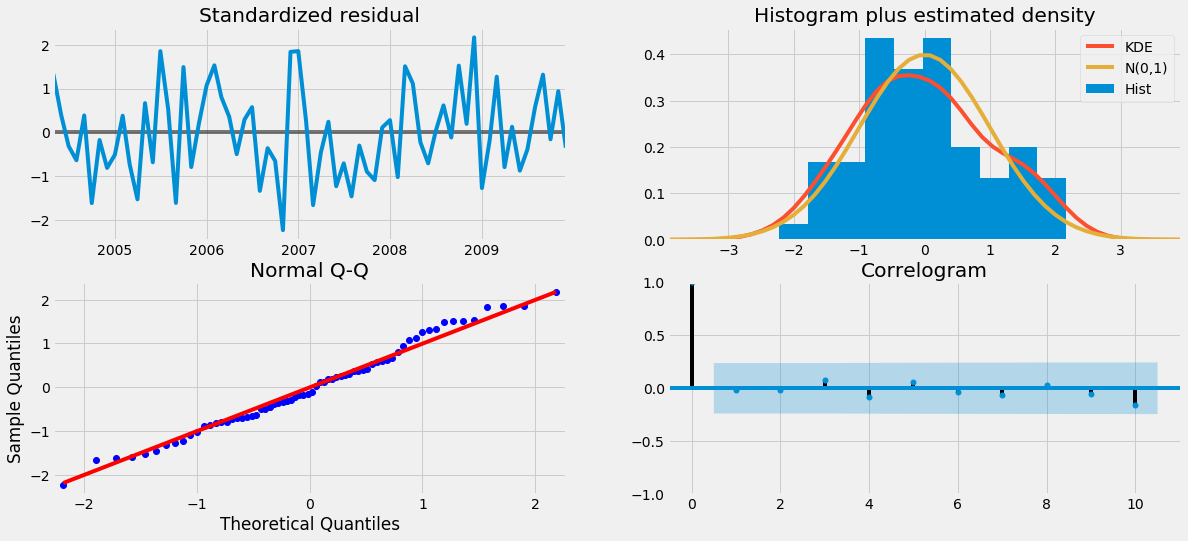

In [43]:

model_fit.plot_diagnostics(figsize=(18, 8))
pyplot.show()

From the residual graph, we can see that there is not much of a pattern there, so no correlation between is existing. From the Normal Q-Q plot, we can see that the errors are normally distributed.The Correlogram shows that the values are close to zero, so correlation is not significant. Hence, our model is performing well

### one-step Prediction for the test data

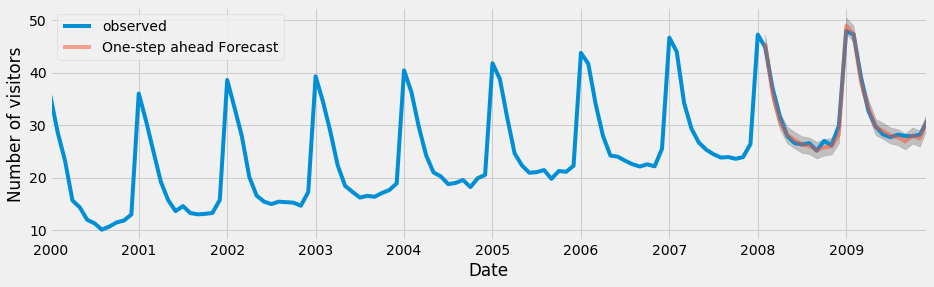

In [47]:
pred = model_fit.get_prediction(start = pd.to_datetime('2008-02-01'),dynamic=False)
pred_ci = pred.conf_int()
ax = monthly_average.tail(500).plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.5, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Number of visitors')
pyplot.legend()
pyplot.show()

### Evaluate the performance of the model by finding MAE

In [56]:
y_forecasted = pred.predicted_mean
y_truth = monthly_average['2008-02-01':]
mae = (np.mean(abs(y_forecasted - y_truth)))


In [57]:
mae

0.6029943654706763